In [1]:
from paths import *
from utils import *

import re
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.calibration import calibration_curve

from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
sns.set_context('notebook', font_scale=1.4)
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
ALPHA = 0.05
NUM_PREDS_PER_VIGNETTE = 47  # This is inferred and needs to be verified. 

# Diagnosis

## Tables

### GPT3

In [2]:
# Read original vignettes
vignettes20 = parse_vignettes_2020(RAW/'vignettes-2020.tsv').reset_index(drop=True)
print(vignettes20.shape)
vignettes20.head()

(48, 4)


,Correct Diagnosis,Correct Triage,Problem,Additional Details
0,Liver failure,Emergent,Confused and sleepy for several hours.,48-year-old female; Can't answer where she is ...
1,Appendicitis,Emergent,Sudden severe abdominal pain.,12-year-old female; Temperature 104 F (40 C); ...
2,Heart attack,Emergent,Chest pain for 1 day.,64-year-old male; Pain is in middle of chest u...
3,Kidney stones,Emergent,Left-sided pain between armpit and hip for 1 h...,45-year-old male; Severe pain; Pain starts on ...
4,Meningitis,Emergent,Headache for 3 days.,18-year-old male; Has fever 102; Neck stiff; L...


In [3]:
# Read the graded vignettes
gpt3_dx_graded = pd.read_excel(PROCESSED/'vignettes_diagnosis_predictions_instruct_graded.xlsx', 
                                 sheet_name=1, index_col=[0, 1, 2, 3, 4, 7]).reset_index()
gpt3_dx_graded['Additional Details'] = gpt3_dx_graded['Additional Details'].map(
    lambda s: s+'.' if not s.endswith('.') else s)
gpt3_dx_graded['Problem'] = gpt3_dx_graded['Problem'].map(
    lambda s: s+'.' if not s.endswith('.') else s)
gpt3_dx_graded['Top-1'] = gpt3_dx_graded['Top Dx Correct?'] == 'Yes'
gpt3_dx_graded['Top-3'] = gpt3_dx_graded['Correct Dx in Top-3?'] == 'Yes'

# Add triage info
adp2triage = vignettes20.set_index(['Additional Details', 'Problem'])['Correct Triage'].to_dict()
gpt3_dx_graded['Correct Triage'] = gpt3_dx_graded.apply(
    lambda row: adp2triage[(row["Additional Details"], row["Problem"])], axis=1)
print(gpt3_dx_graded.shape)
gpt3_dx_graded.head()

(122, 12)


,Problem,Additional Details,Correct Diagnosis,Top Predicted Dx,Top Dx Correct?,Correct Dx in Top-3?,Top-3 Predicted Dx,Predicted Dx Correct?,Number of predictions,Top-1,Top-3,Correct Triage
0,Dry itchy skin in front of elbows and behind k...,12-year-old female; Brother has asthma; Recent...,Eczema,Atopic dermatitis,Yes,Yes,Atopic dermatitis,Yes,43,True,True,Self-care
1,Dry itchy skin in front of elbows and behind k...,12-year-old female; Brother has asthma; Recent...,Eczema,Atopic dermatitis,Yes,Yes,Eczema,Yes,4,True,True,Self-care
2,Sudden severe abdominal pain.,12-year-old female; Temperature 104 F (40 C); ...,Appendicitis,Appendicitis,Yes,Yes,Appendicitis,Yes,45,True,True,Emergent
3,Sudden severe abdominal pain.,12-year-old female; Temperature 104 F (40 C); ...,Appendicitis,Appendicitis,Yes,Yes,Viral gastroenteritis,No,1,True,True,Emergent
4,Sudden severe abdominal pain.,12-year-old female; Temperature 104 F (40 C); ...,Appendicitis,Appendicitis,Yes,Yes,Acute appendicitis,Yes,1,True,True,Emergent


In [4]:
# Get per vignette performance
# Get number of total and correct predictions
gpt3_dx_graded["Number of correct predictions"] =\
    (gpt3_dx_graded["Predicted Dx Correct?"] == "Yes") * (gpt3_dx_graded["Number of predictions"])
per_vignette_dx_gpt3 = (gpt3_dx_graded
 .groupby(["Problem", "Additional Details", "Correct Diagnosis"])
 [["Number of predictions", "Number of correct predictions"]]
 .agg(sum))


# Find probability of correct prediction
per_vignette_dx_gpt3["Pr(correct prediction)"] =\
    per_vignette_dx_gpt3["Number of correct predictions"] / NUM_PREDS_PER_VIGNETTE # per_vignette_dx_gpt3["Number of predictions"]
per_vignette_dx_gpt3.reset_index(inplace=True)

# Set index to match original file
adp2idx = vignettes20.reset_index().set_index(["Additional Details", "Problem"])["index"]
per_vignette_dx_gpt3.index = per_vignette_dx_gpt3.apply(
    lambda row: adp2idx[(row["Additional Details"], row["Problem"])], axis=1)
per_vignette_dx_gpt3.sort_index(inplace=True)

# Add triage info
per_vignette_dx_gpt3['Correct Triage'] = per_vignette_dx_gpt3.apply(
    lambda row: adp2triage[(row["Additional Details"], row["Problem"])], axis=1)
print(per_vignette_dx_gpt3.shape)
per_vignette_dx_gpt3.head()

(48, 7)


,Problem,Additional Details,Correct Diagnosis,Number of predictions,Number of correct predictions,Pr(correct prediction),Correct Triage
0,Confused and sleepy for several hours.,48-year-old female; Can't answer where she is ...,Liver failure,42,0,0.000000,Emergent
1,Sudden severe abdominal pain.,12-year-old female; Temperature 104 F (40 C); ...,Appendicitis,47,46,0.978723,Emergent
2,Chest pain for 1 day.,64-year-old male; Pain is in middle of chest u...,Heart attack,46,46,0.978723,Emergent
3,Left-sided pain between armpit and hip for 1 h...,45-year-old male; Severe pain; Pain starts on ...,Kidney stones,46,33,0.702128,Emergent
4,Headache for 3 days.,18-year-old male; Has fever 102; Neck stiff; L...,Meningitis,47,47,1.000000,Emergent


In [5]:
# Calculate aggregated performance
gpt3_dx_perf = gpt3_dx_graded.drop_duplicates(
    ["Problem", "Additional Details", "Correct Diagnosis"], keep="first")
gpt3_dx_perf = gpt3_dx_perf.groupby('Correct Triage')\
    [['Top-1', 'Top-3']].\
    agg([len, sum])
gpt3_dx_perf.loc['All'] = gpt3_dx_perf.sum()
gpt3_dx_perf.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)
gpt3_dx_perf

Top-1           Top-3          
                   N # Correct     N # Correct
Correct Triage                                
1-day             12         7    12        10
1-week            12         8    12        11
Emergent          12         8    12         9
Self-care         12         8    12        12
All               48        31    48        42

In [6]:
# Calculate aggregated performance
gpt3_dx_perf = gpt3_dx_graded.drop_duplicates(
    ["Problem", "Additional Details", "Correct Diagnosis"], keep="first")
gpt3_dx_perf = gpt3_dx_perf.groupby('Correct Triage')\
    [['Top-1', 'Top-3']].\
    agg([len, sum])
gpt3_dx_perf.loc['All'] = gpt3_dx_perf.sum()
gpt3_dx_perf.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)

# Get confidence intervals
data = []
for i, row in gpt3_dx_perf.iterrows():
    for col in ['Top-1', 'Top-3']:
        n, total = row[col].values
        row.loc[(col, 'LB')], row.loc[(col, 'UB')] =\
            proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
        row.loc[(col, 'LB')]*= 100; row.loc[(col, 'UB')] *= 100
        row.loc[(col, 'Mean')] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_dx_perf = pd.DataFrame(data)
gpt3_dx_perf.sort_index(axis=1, inplace=True)
gpt3_dx_perf

Top-1                                            Top-3  \
          # Correct         LB       Mean     N         UB # Correct   
1-day           7.0  31.951131  58.333333  12.0  80.673969      10.0   
1-week          8.0  39.062209  66.666667  12.0  86.187991      11.0   
Emergent        8.0  39.062209  66.666667  12.0  86.187991       9.0   
Self-care       8.0  39.062209  66.666667  12.0  86.187991      12.0   
All            31.0  50.439057  64.583333  48.0  76.566356      42.0   

                                                    
                  LB        Mean     N          UB  
1-day      55.196914   83.333333  12.0   95.303486  
1-week     64.612009   91.666667  12.0   98.513491  
Emergent   46.769467   75.000000  12.0   91.105833  
Self-care  75.750599  100.000000  12.0  100.000000  
All        75.299542   87.500000  48.0   94.142949

### Physician

In [7]:
# Read Physician dx performance (only top-3 available)
md_dx_perf = pd.read_csv(RAW/'MD-dx.tsv', sep='\t')

# Get triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
md_dx_perf['Correct Triage'] = md_dx_perf['Name'].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])
print(md_dx_perf.shape)
md_dx_perf.head()

(48, 4)


,Name,N,Accuracy,Correct Triage
0,dx1anycorrect,16,0.812500,Emergent
1,dx2anycorrect,12,1.000000,Emergent
2,dx3anycorrect,15,1.000000,Emergent
3,dx4anycorrect,12,0.833333,Emergent
4,dx5anycorrect,16,1.000000,Emergent


In [8]:
# Calculate aggregate statistics
md_dx_perf['# Correct'] = (md_dx_perf['N'] * md_dx_perf['Accuracy']).map(round)
del md_dx_perf['Accuracy']
md_dx_perf = md_dx_perf.groupby('Correct Triage').agg(sum)
md_dx_perf.loc['All'] = md_dx_perf.sum()

# Get confidence intervals
data = []
for i, row in md_dx_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
md_dx_perf = pd.DataFrame(data)
md_dx_perf.columns = pd.MultiIndex.from_product([['Top-3'], md_dx_perf.columns])
md_dx_perf

Top-3                                           
               N # Correct         LB         UB       Mean
1-day      172.0     159.0  87.499282  95.530057  92.441860
1-week     155.0     153.0  95.417912  99.645431  98.709677
Emergent   179.0     169.0  90.023082  96.937501  94.413408
Self-care  160.0     156.0  93.749011  99.023601  97.500000
All        666.0     637.0  93.816405  96.951342  95.645646

### Human

In [9]:
# Read dx performance
human_dx_perf = pd.read_csv(RAW/'human-dx.tsv', sep='\t')

# Remove pre-evaluations
human_dx_perf = human_dx_perf[~human_dx_perf["Name"].map(lambda s: 'pre' in s)].\
    reset_index(drop=True)

# Separate Top-1 and Top-3 rows
top1 = human_dx_perf.loc[~human_dx_perf['Name'].str.contains("any")]
top1['Name'] = top1['Name'].map(lambda s: s.split("post")[0])

top3 = human_dx_perf.loc[human_dx_perf['Name'].str.contains("any")]
top3['Name'] = top3['Name'].map(lambda s: s.split("any")[0])

# Concat with multindex (similar to gpt3 perf)
human_dx_perf = top1.merge(top3, on='Name', how='outer', suffixes=("_top1", "_top3"))
assert (human_dx_perf["N_top1"]-human_dx_perf["N_top3"]).sum() == 0
human_dx_perf.set_index("Name", inplace=True)
human_dx_perf.columns = pd.MultiIndex.from_product([["Top-1", "Top-3"], ["N", "Accuracy"]])
for col in ["Top-1", "Top-3"]:
    human_dx_perf[(col, "# Correct")] = (human_dx_perf[(col, "N")] *  human_dx_perf[(col, "Accuracy")]).map(round)
    del human_dx_perf[(col, "Accuracy")]
    
# Add triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
human_dx_perf['Correct Triage'] = human_dx_perf.index.map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

/tmp/ipykernel_7768/1576918246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['Name'] = top1['Name'].map(lambda s: s.split("post")[0])
/tmp/ipykernel_7768/1576918246.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3['Name'] = top3['Name'].map(lambda s: s.split("any")[0])


In [10]:
# Get per vignette performance
per_vignette_dx_human = human_dx_perf.copy()["Top-3"]
per_vignette_dx_human["% Correct"] = per_vignette_dx_human["# Correct"] / per_vignette_dx_human["N"]
per_vignette_dx_human['Correct Triage'] = per_vignette_dx_human.index.map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

In [11]:
# Aggregate over vignettes
human_dx_perf = human_dx_perf.groupby('Correct Triage').agg(sum)
human_dx_perf.loc['All'] = human_dx_perf.sum()

# Get confidence intervals
data = []
for i, row in human_dx_perf.iterrows():
    for col in ['Top-1', 'Top-3']:
        n, total = row[col].values
        row.loc[(col, 'LB')], row.loc[(col, 'UB')] =\
            proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
        row.loc[(col, 'LB')]*= 100; row.loc[(col, 'UB')] *= 100
        row.loc[(col, 'Mean')] = (total/n)*100
    row.name = i
    data.append(row)
    
human_dx_perf = pd.DataFrame(data)
human_dx_perf.sort_index(1, inplace=True)
human_dx_perf

/home/rt156/.local/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/tmp/ipykernel_7768/1586771555.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  human_dx_perf.sort_index(1, inplace=True)


Top-1                                              Top-3  \
          # Correct         LB       Mean       N         UB # Correct   
1-day         332.0  24.852226  27.280197  1217.0  29.851147     507.0   
1-week        573.0  43.059481  45.803357  1251.0  48.572928     741.0   
Emergent      381.0  27.543072  30.000000  1270.0  32.577554     554.0   
Self-care     688.0  51.759751  54.516640  1262.0  57.246116     898.0   
All          1974.0  38.133691  39.480000  5000.0  40.842461    2700.0   

                                                    
                  LB       Mean       N         UB  
1-day      38.920518  41.659819  1217.0  44.451606  
1-week     56.485320  59.232614  1251.0  61.923380  
Emergent   40.917897  43.622047  1270.0  46.364665  
Self-care  68.596189  71.156894  1262.0  73.589189  
All        52.615994  54.000000  5000.0  55.377864

## Figures

### Comparative diagnostic performance

In [12]:
dx_perf = pd.concat([human_dx_perf, gpt3_dx_perf, md_dx_perf])
dx_perf['Respondent'] = ['Lay individuals (with internet access)']*5 +\
    ['GPT-3']*5 +\
    ['Physicians']*5
dx_perf.index.name = "Case Acuity"
dx_perf.reset_index(inplace=True)

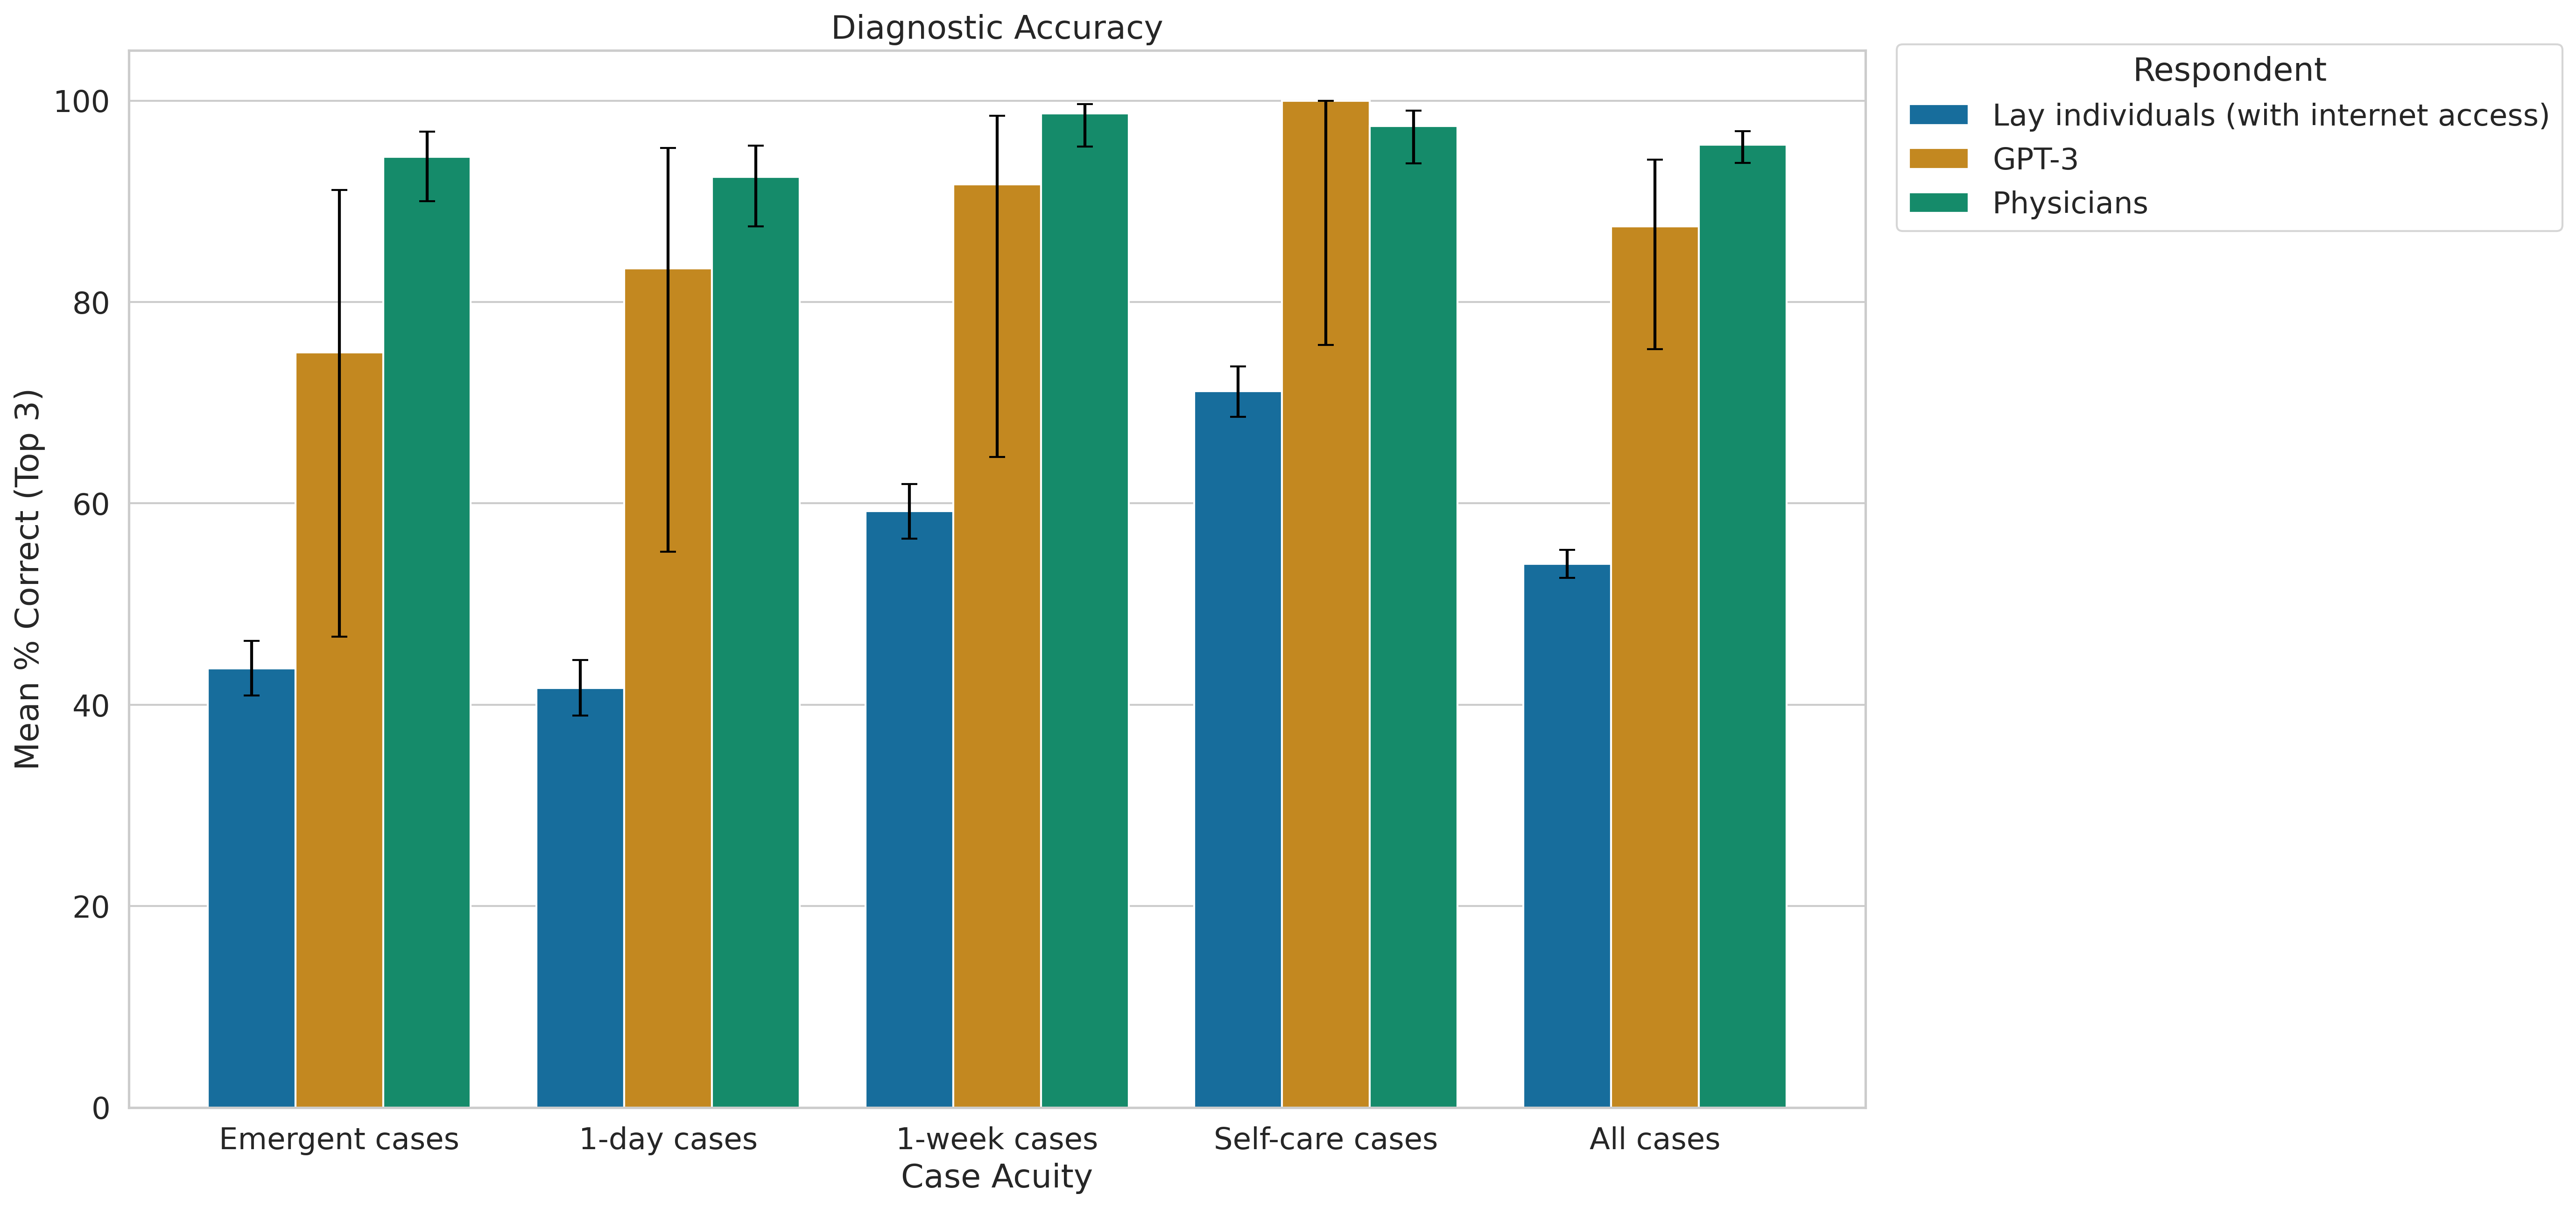

In [13]:
row_order = ["Emergent", "1-day", "1-week", "Self-care", "All"]

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=dx_perf, 
            x=('Case Acuity', ''), 
            y=('Top-3', 'Mean'),
            hue=( 'Respondent', ''),
            ax=ax,
            order=row_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct (Top 3)")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Diagnostic Accuracy")

tmp = dx_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp[("Top-3", "LB")] = -(tmp[("Top-3", "LB")]-tmp[("Top-3", "Mean")])
tmp[("Top-3", "UB")] = tmp[("Top-3", "UB")] - tmp[("Top-3", "Mean")]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[[("Top-3", "LB"), ("Top-3", "UB")]].values.T,
            ls='none', fmt='k', capsize=4);

### Confidence comparison between GPT-3 and lay individuals

In [14]:
per_vignette_dx_human.index = per_vignette_dx_human.index.map(lambda s: int(s[2:])-1)

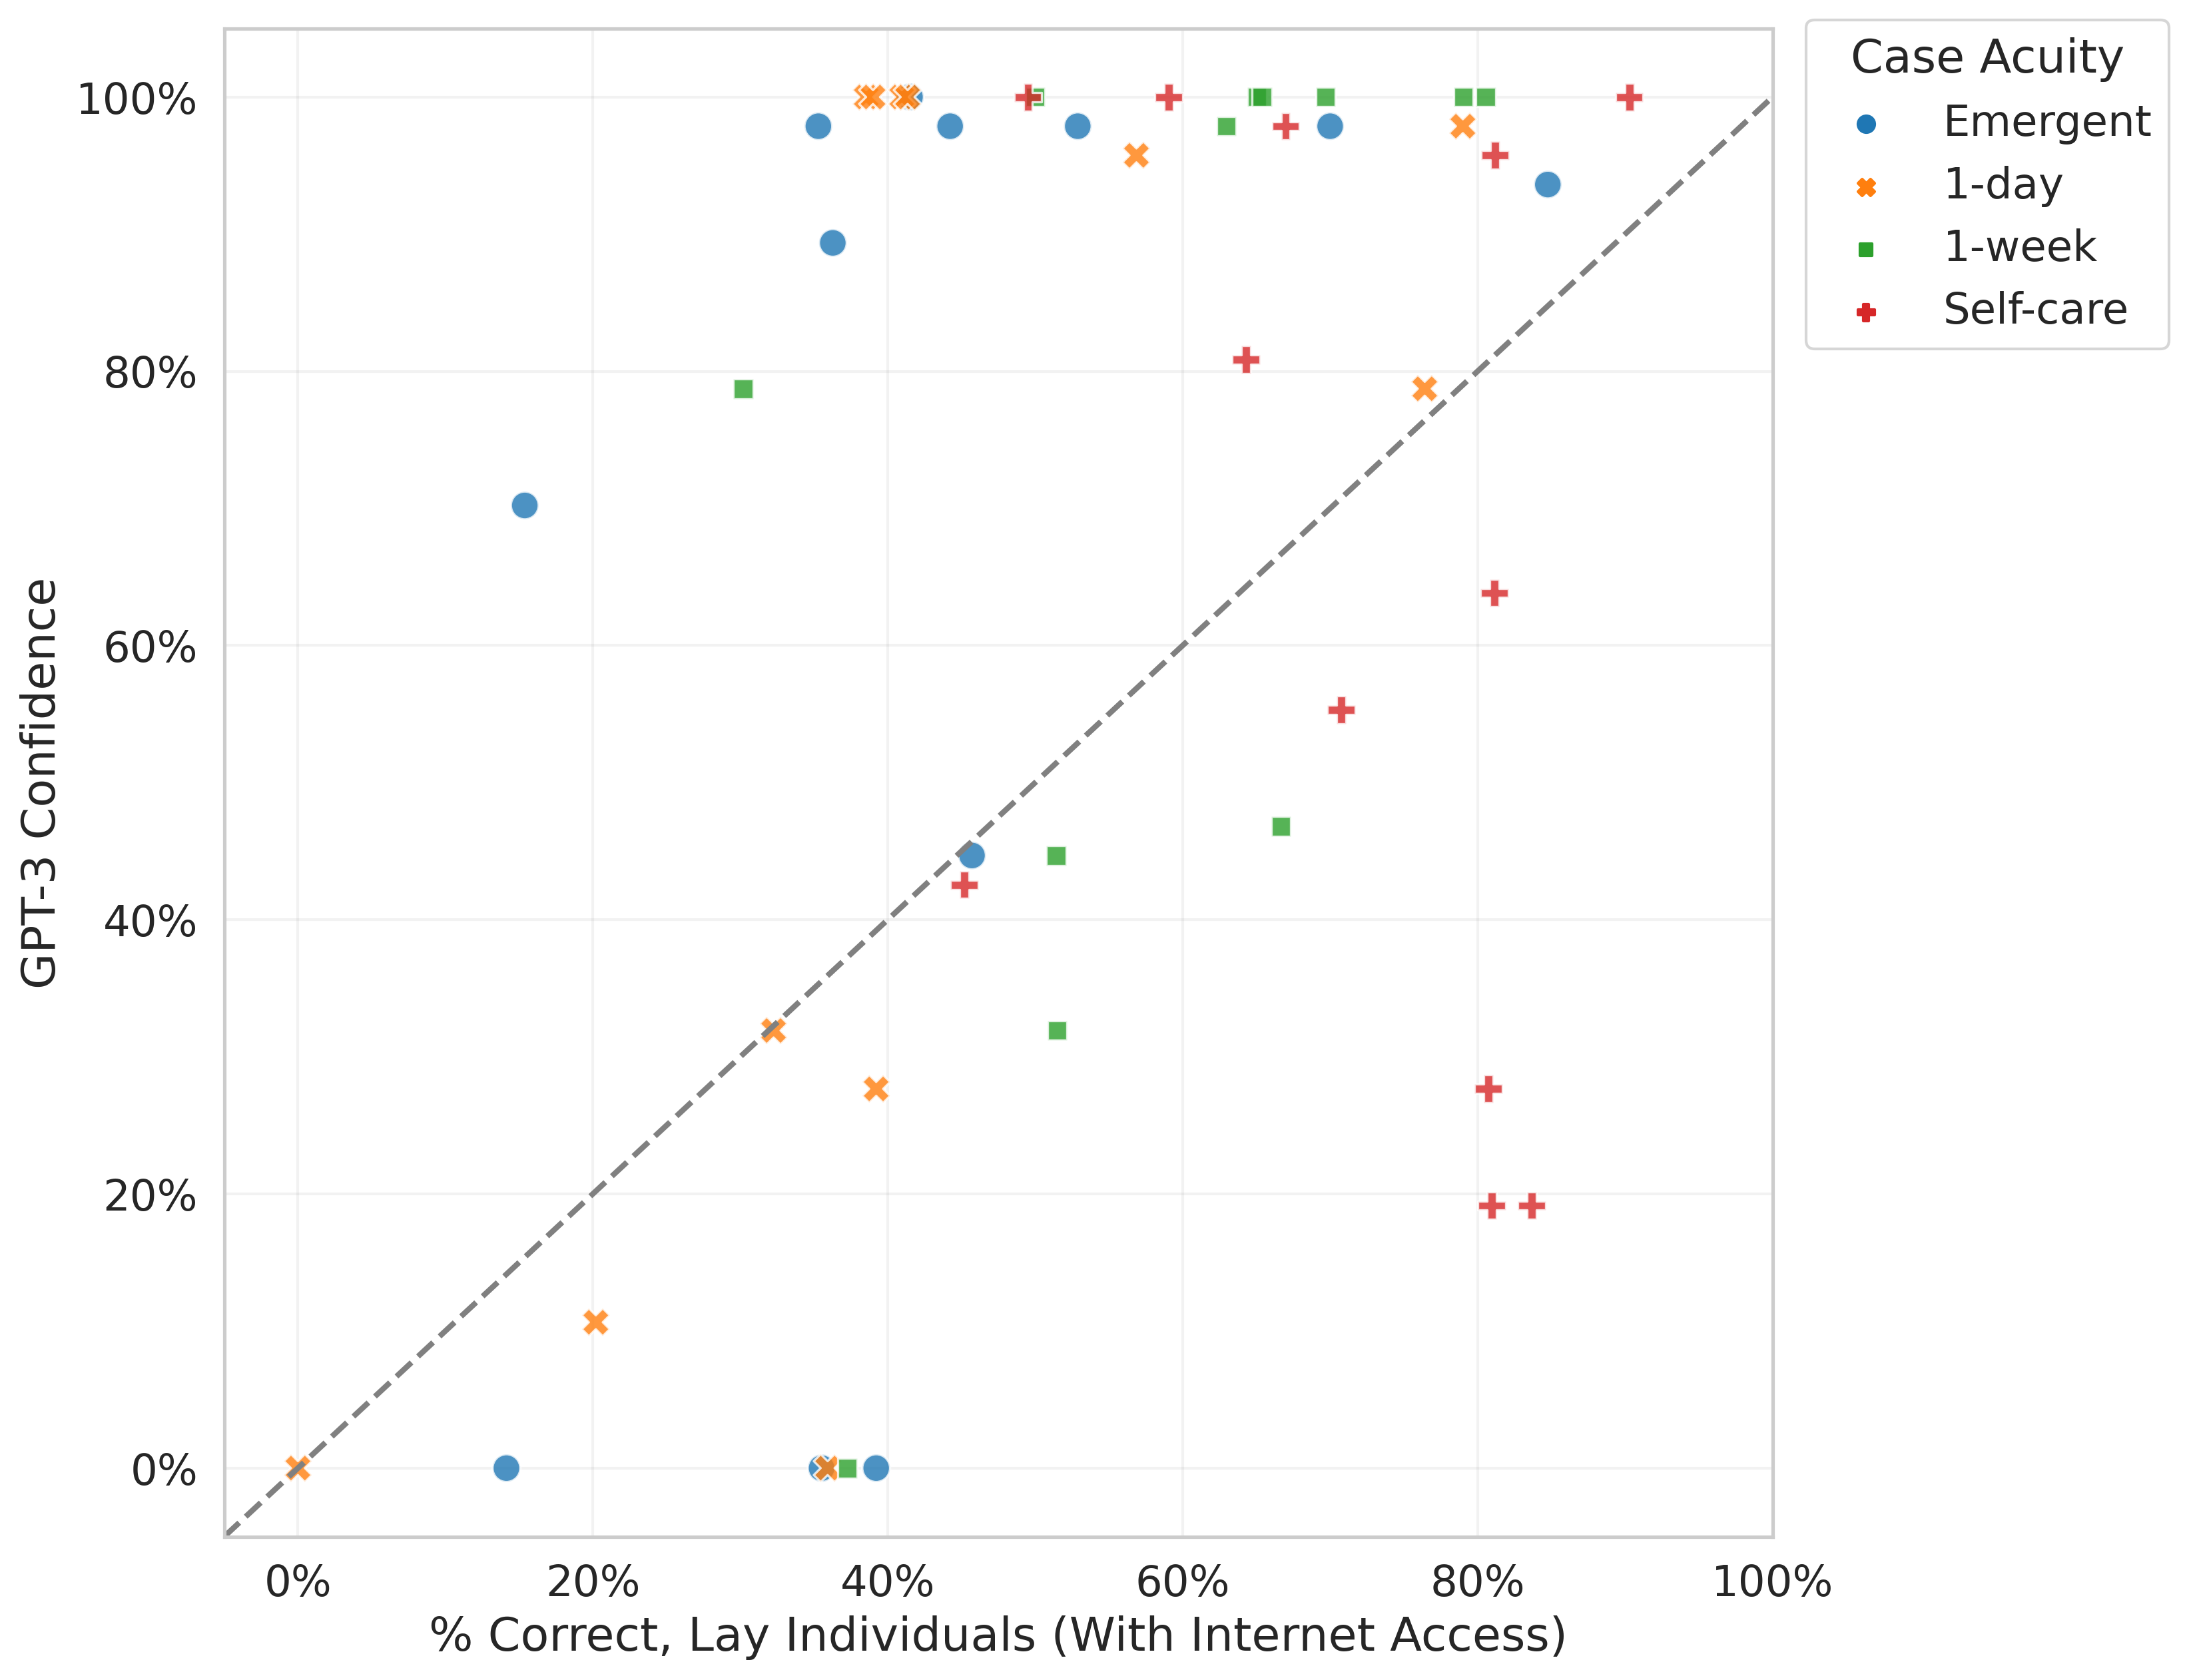

In [15]:
assert (per_vignette_dx_human["Correct Triage"] == per_vignette_dx_gpt3["Correct Triage"]).all()

fig, ax = plt.subplots(figsize=(10, 10))

g = sns.scatterplot(
    x=per_vignette_dx_human["% Correct"]*100,
    y=per_vignette_dx_gpt3["Pr(correct prediction)"]*100,
    hue=per_vignette_dx_human["Correct Triage"],
    s=100,
    alpha=0.8,
    ax=ax,
    style=per_vignette_dx_human["Correct Triage"],
)
g.legend(loc='upper right', bbox_to_anchor=(1.27, 1.02), title="Case Acuity")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed")
ax.set_xlim((-5, 100))
ax.grid(color="grey", alpha=0.1)
ax.set_ylabel("GPT-3 Confidence")
ax.set_xlabel("% Correct, Lay Individuals (With Internet Access)")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

### Calibration curve for GPT-3's top-1 diagnosis

/tmp/ipykernel_7768/3163907880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpt3_dx_graded_top1["Pr(prediction)"] = gpt3_dx_graded_top1["Number of predictions"] / NUM_PREDS_PER_VIGNETTE


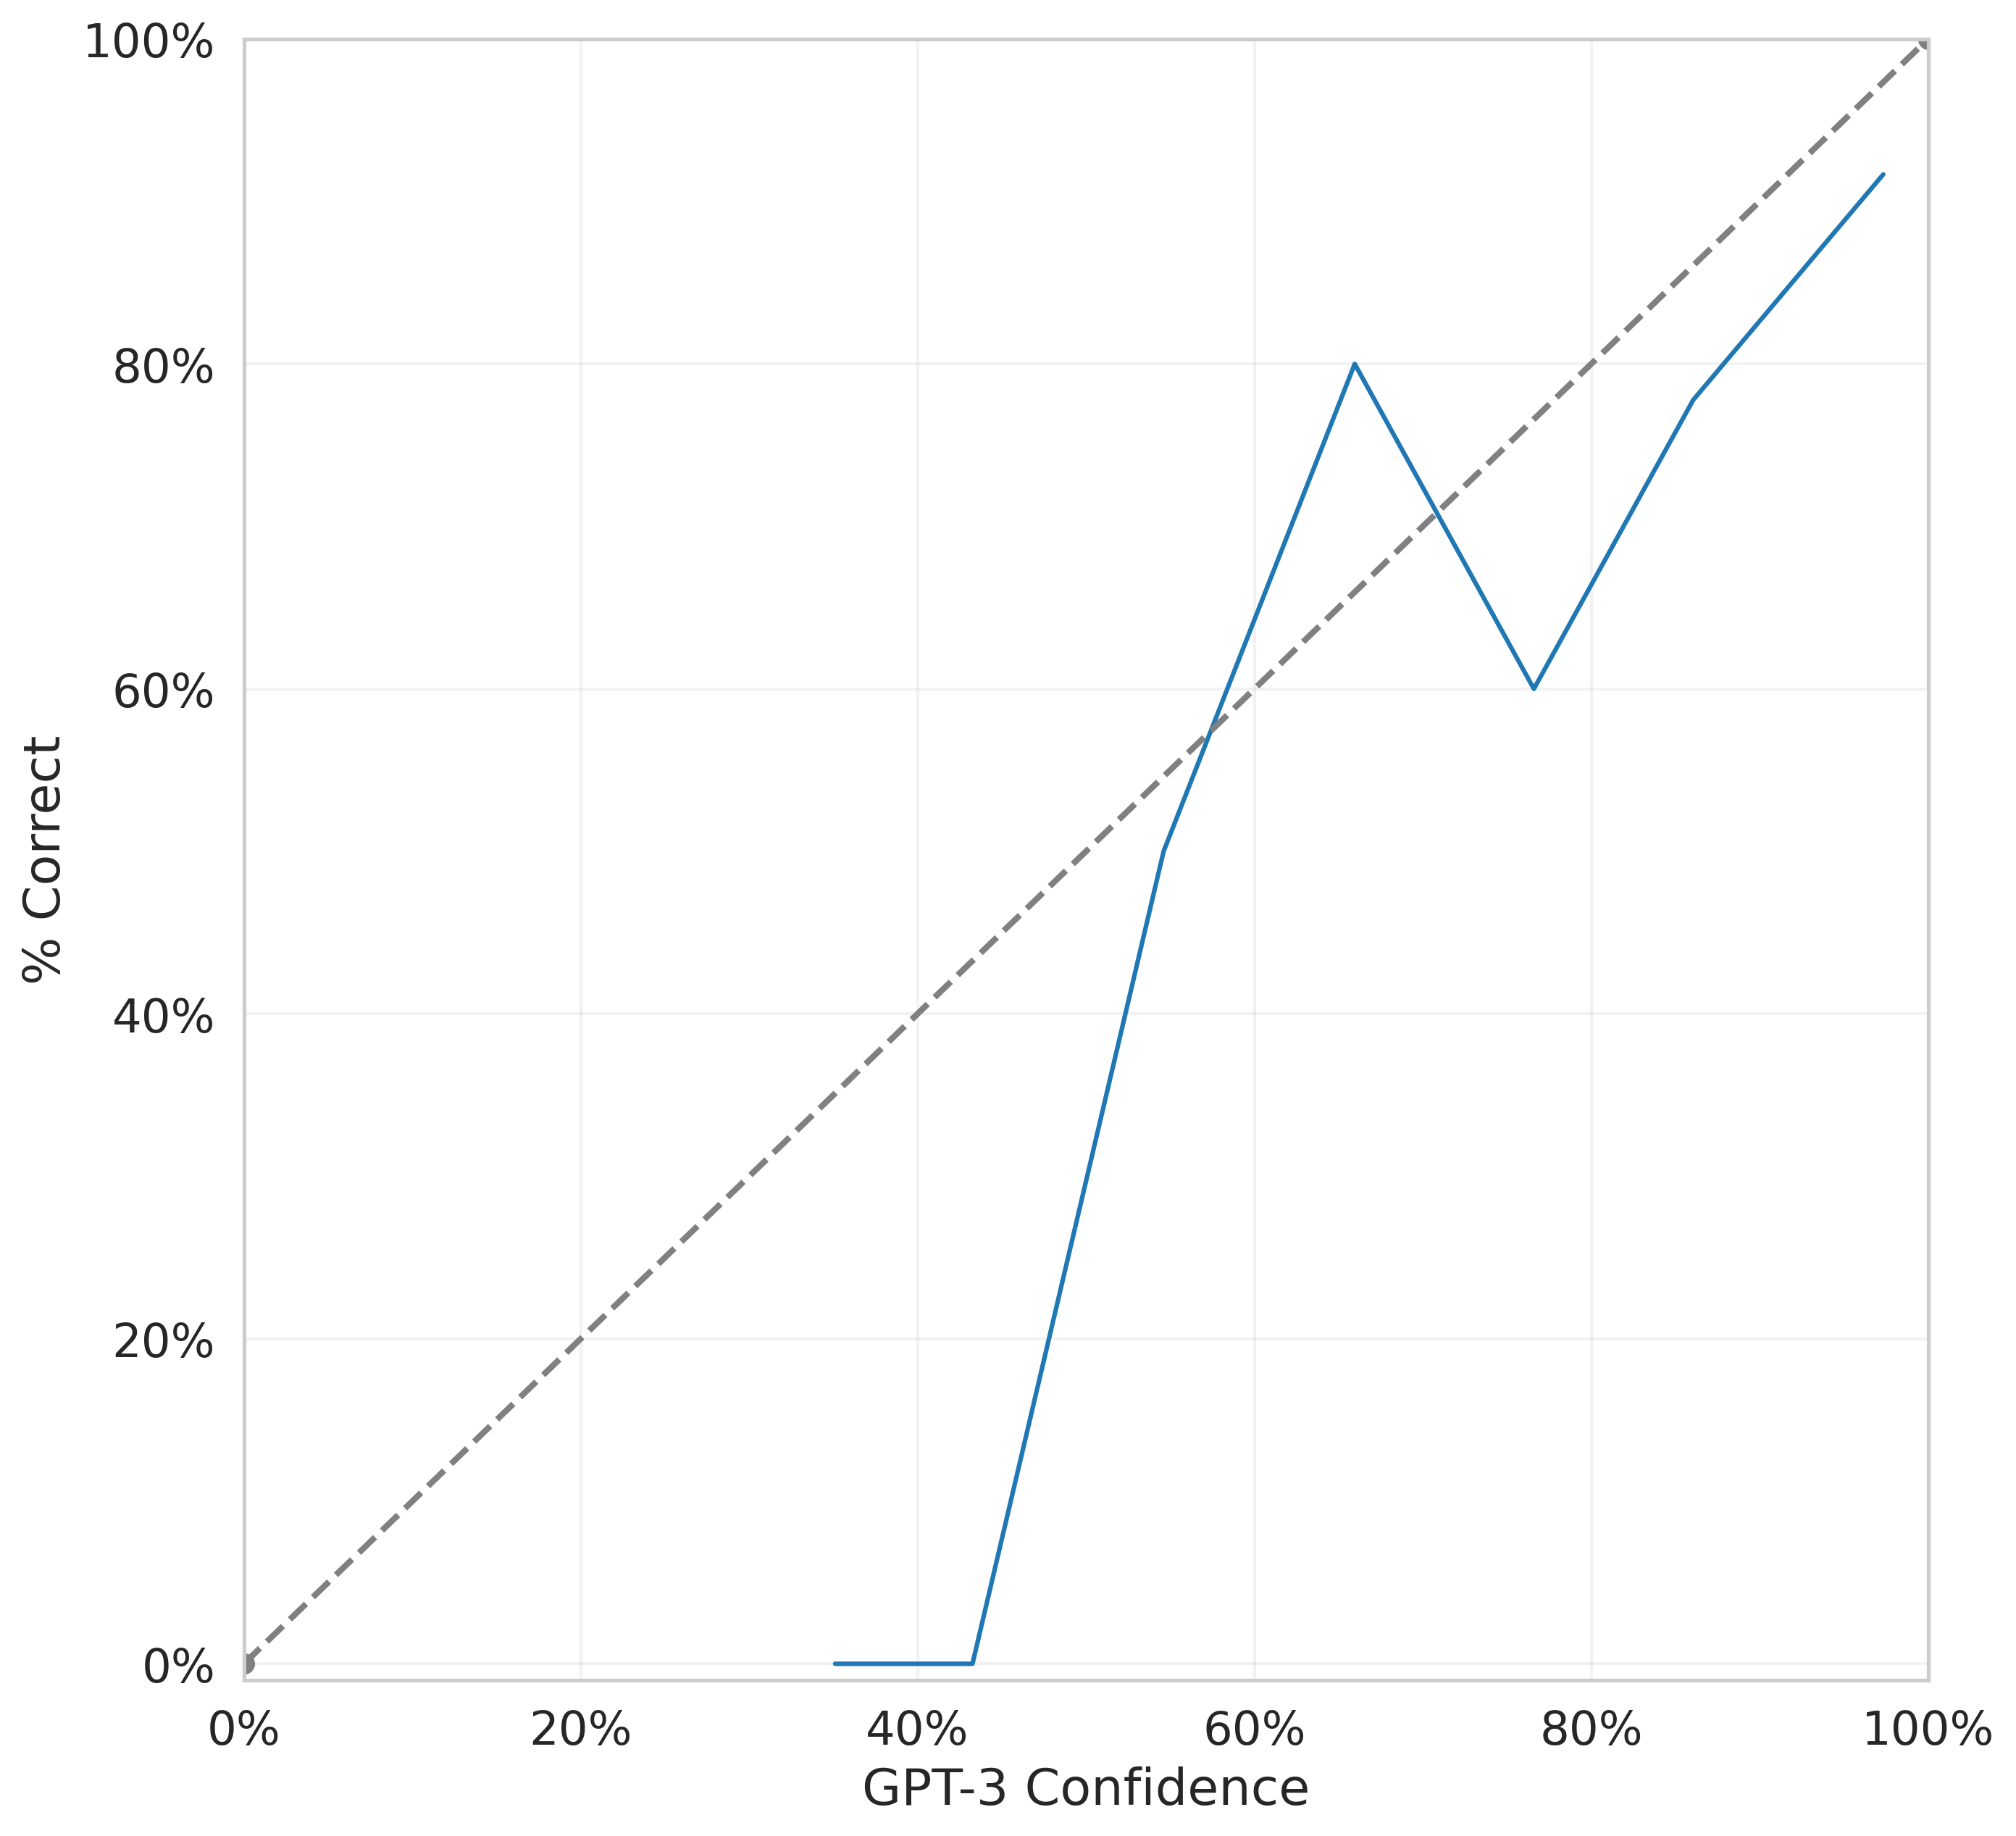

In [16]:
# Get probability of top-1 predictions (confidence)

# Subset to keep rows that correspond to just the top predicted dx
gpt3_dx_graded_top1 = gpt3_dx_graded.loc[gpt3_dx_graded["Top Predicted Dx"] == gpt3_dx_graded["Top-3 Predicted Dx"]]
gpt3_dx_graded_top1["Pr(prediction)"] = gpt3_dx_graded_top1["Number of predictions"] / NUM_PREDS_PER_VIGNETTE

# Get empirical and true probabilities
y, x = calibration_curve(
    gpt3_dx_graded_top1["Predicted Dx Correct?"],
    gpt3_dx_graded_top1["Pr(prediction)"],
    n_bins=10
)
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=x*100, y=y*100, ax=ax)
ax.set_xlabel("GPT-3 Confidence")
ax.set_ylabel("% Correct")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed",  marker='o')
ax.grid(color="grey", alpha=0.1)
ax.set_ylim(-1,100)
ax.set_xlim(0,100)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

# Exact and Dichotomized Triage

## Tables

### GPT-3

In [17]:
# Dichotomized
per_vignette_gpt3_dich = pd.read_csv(PROCESSED/"vignettes20_triage_prediction_dich.tsv", 
                                    sep="\t")
# Add correct triage info
ad2triage = vignettes20.set_index('Additional Details')['Correct Triage'].to_dict()
per_vignette_gpt3_dich["Correct Triage"] = per_vignette_gpt3_dich['Additional Details'].map(
    lambda s: ad2triage[s]
)

# Sort according to original file
adp2idx = vignettes20.reset_index().set_index(["Additional Details", "Problem"])["index"]
per_vignette_gpt3_dich.index = per_vignette_gpt3_dich.apply(
    lambda row: adp2idx[(row["Additional Details"], row["Problem"])], axis=1)
per_vignette_gpt3_dich.sort_index(inplace=True)

# Exact
per_vignette_gpt3_exact = pd.read_csv(PROCESSED/"vignettes20_triage_prediction_exact.tsv", 
                                       sep="\t")
per_vignette_gpt3_exact.index = per_vignette_gpt3_exact.apply(
    lambda row: adp2idx[(row["Additional Details"], row["Problem"])], axis=1)
per_vignette_gpt3_exact.sort_index(inplace=True)

In [18]:
# Aggregate over vignettes
gpt3_triage_perf_dich = per_vignette_gpt3_dich.groupby('Correct Triage').agg({"Correct": [len, sum]})
gpt3_triage_perf_dich.loc['All'] = gpt3_triage_perf_dich.sum()
gpt3_triage_perf_dich.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)
gpt3_triage_perf_dich = gpt3_triage_perf_dich["Correct"]

In [19]:
# Get confidence intervals
data = []
for i, row in gpt3_triage_perf_dich.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_triage_perf_dich = pd.DataFrame(data)
gpt3_triage_perf_dich

,N,# Correct,LB,UB,Mean
1-day,12.0,7.0,31.951131,80.673969,58.333333
1-week,12.0,11.0,64.612009,98.513491,91.666667
Emergent,12.0,10.0,55.196914,95.303486,83.333333
Self-care,12.0,6.0,25.378160,74.621840,50.000000
All,48.0,34.0,56.820740,81.758421,70.833333


In [20]:
# Aggregate over vignettes
gpt3_triage_perf_exact = per_vignette_gpt3_exact.groupby('Correct Triage').agg({"Correct": [len, sum]})
gpt3_triage_perf_exact.loc['All'] = gpt3_triage_perf_exact.sum()
gpt3_triage_perf_exact.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)
gpt3_triage_perf_exact = gpt3_triage_perf_exact["Correct"]

# Get confidence intervals
data = []
for i, row in gpt3_triage_perf_exact.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_triage_perf_exact = pd.DataFrame(data)
gpt3_triage_perf_exact

,N,# Correct,LB,UB,Mean
1-day,12.0,2.0,4.696514,44.803086,16.666667
1-week,12.0,11.0,64.612009,98.513491,91.666667
Emergent,12.0,6.0,25.378160,74.621840,50.000000
Self-care,12.0,2.0,4.696514,44.803086,16.666667
All,48.0,21.0,30.701269,57.724983,43.750000


### Physician

In [21]:
# Read dx performance (only top-3 available)
md_triage_perf = pd.read_csv(RAW/'MD-triage.tsv', sep='\t')

# Get triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
md_triage_perf['Correct Triage'] = md_triage_perf['Name'].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

# Calculate aggregate statistics
md_triage_perf['# Correct'] = (md_triage_perf['N'] * md_triage_perf['Accuracy']).map(round)
del md_triage_perf['Accuracy']
md_triage_perf = md_triage_perf.groupby('Correct Triage').agg(sum)
md_triage_perf.loc['All'] = md_triage_perf.sum()

# Get confidence intervals
data = []
for i, row in md_triage_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
md_triage_perf = pd.DataFrame(data)
md_triage_perf

,N,# Correct,LB,UB,Mean
1-day,172.0,156.0,85.424290,94.192884,90.697674
1-week,155.0,129.0,76.556435,88.288097,83.225806
Emergent,179.0,177.0,96.018280,99.693054,98.882682
Self-care,160.0,146.0,85.849368,94.716321,91.250000
All,666.0,608.0,88.906126,93.202855,91.291291


### Human

In [22]:
# Read dx performance (only top-3 available)
per_vignette_human = pd.read_csv(RAW/'human-triage.tsv', sep='\t')

# Remove pre-evaluations
per_vignette_human = per_vignette_human[~per_vignette_human["Name"].map(lambda s: 'pre' in s)].\
    reset_index(drop=True)

# Add triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
per_vignette_human['Correct Triage'] = per_vignette_human["Name"].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

# Calculate aggregate statistics
per_vignette_human['# Correct'] = (per_vignette_human['N'] * per_vignette_human['Accuracy']).map(round)

human_triage_perf = per_vignette_human.drop(columns="Accuracy").groupby('Correct Triage').agg(sum)
human_triage_perf.loc['All'] = human_triage_perf.sum()

# Get confidence intervals
data = []
for i, row in human_triage_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
human_triage_perf = pd.DataFrame(data)
human_triage_perf

,N,# Correct,LB,UB,Mean
1-day,1217.0,968.0,77.182096,81.711710,79.539852
1-week,1251.0,755.0,57.613327,63.026731,60.351719
Emergent,1270.0,1108.0,85.296388,88.967171,87.244094
Self-care,1262.0,875.0,66.734893,71.816539,69.334390
All,5000.0,3706.0,72.887824,75.315142,74.120000


## Figures

### Dichotomized

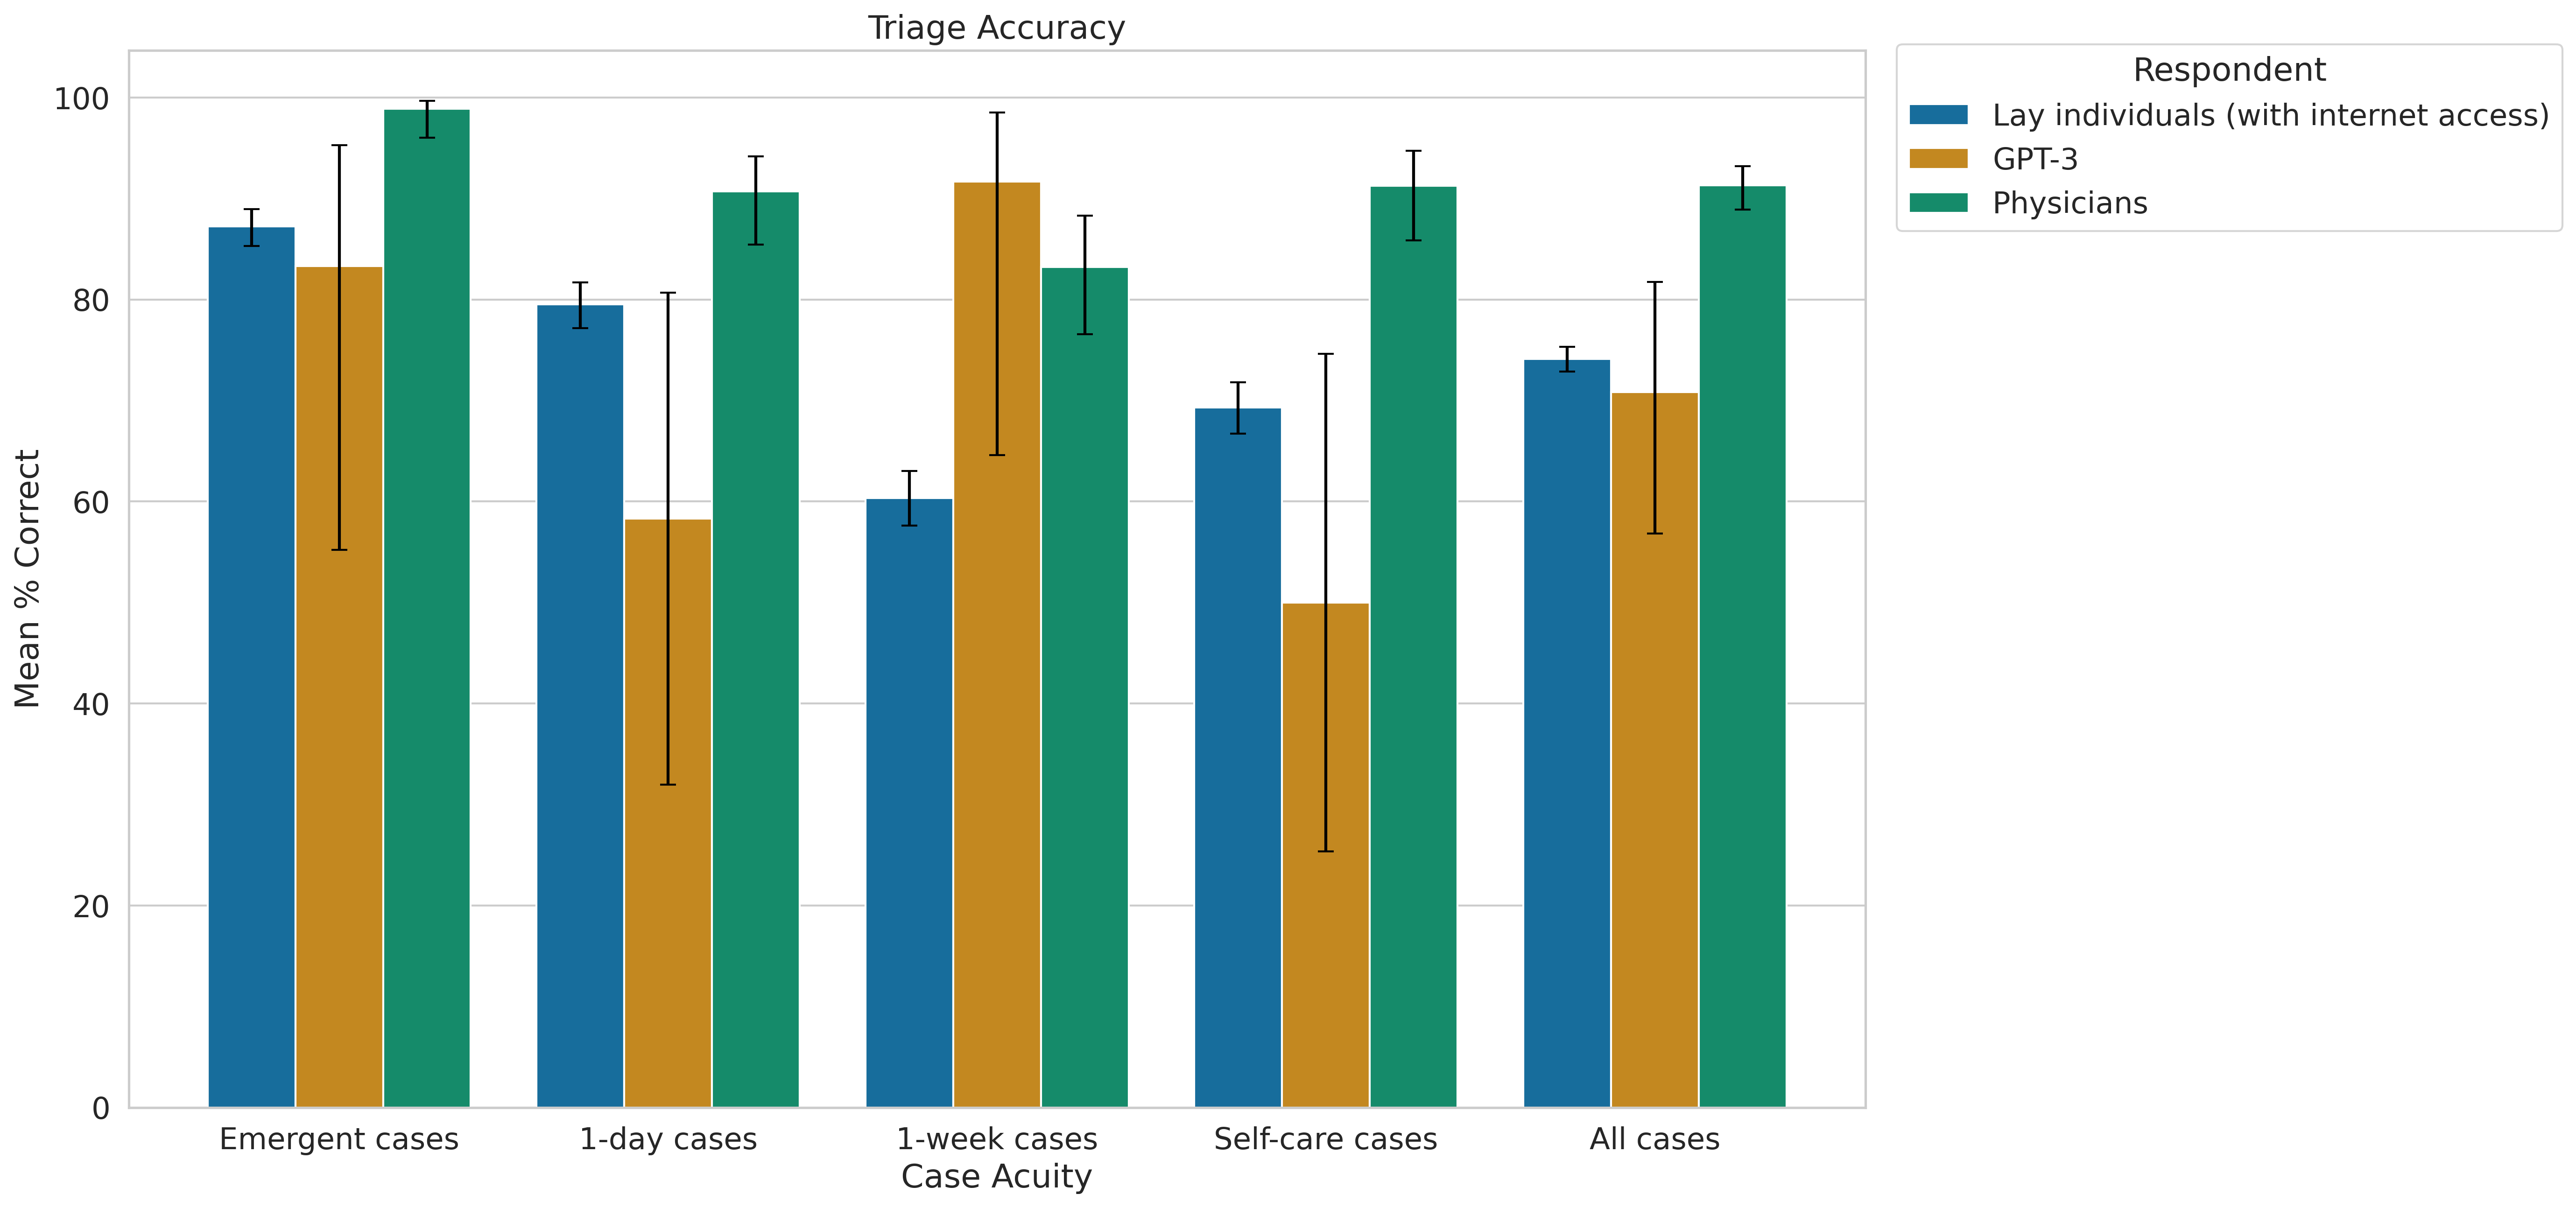

In [23]:
triage_perf = pd.concat([human_triage_perf, gpt3_triage_perf_dich, md_triage_perf])
triage_perf['Respondent'] = ['Lay individuals (with internet access)']*5 +\
    ['GPT-3']*5 +\
    ['Physicians']*5
triage_perf.index.name = "Case Acuity"
triage_perf.reset_index(inplace=True)

row_order = ["Emergent", "1-day", "1-week", "Self-care", "All"]

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=triage_perf, 
            x='Case Acuity', 
            y='Mean',
            hue='Respondent',
            ax=ax,
            order=row_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Triage Accuracy")

tmp = triage_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp["LB"] = -(tmp["LB"]-tmp["Mean"])
tmp["UB"] = tmp["UB"] - tmp["Mean"]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[["LB", "UB"]].values.T,
            ls='none', fmt='k', capsize=4);

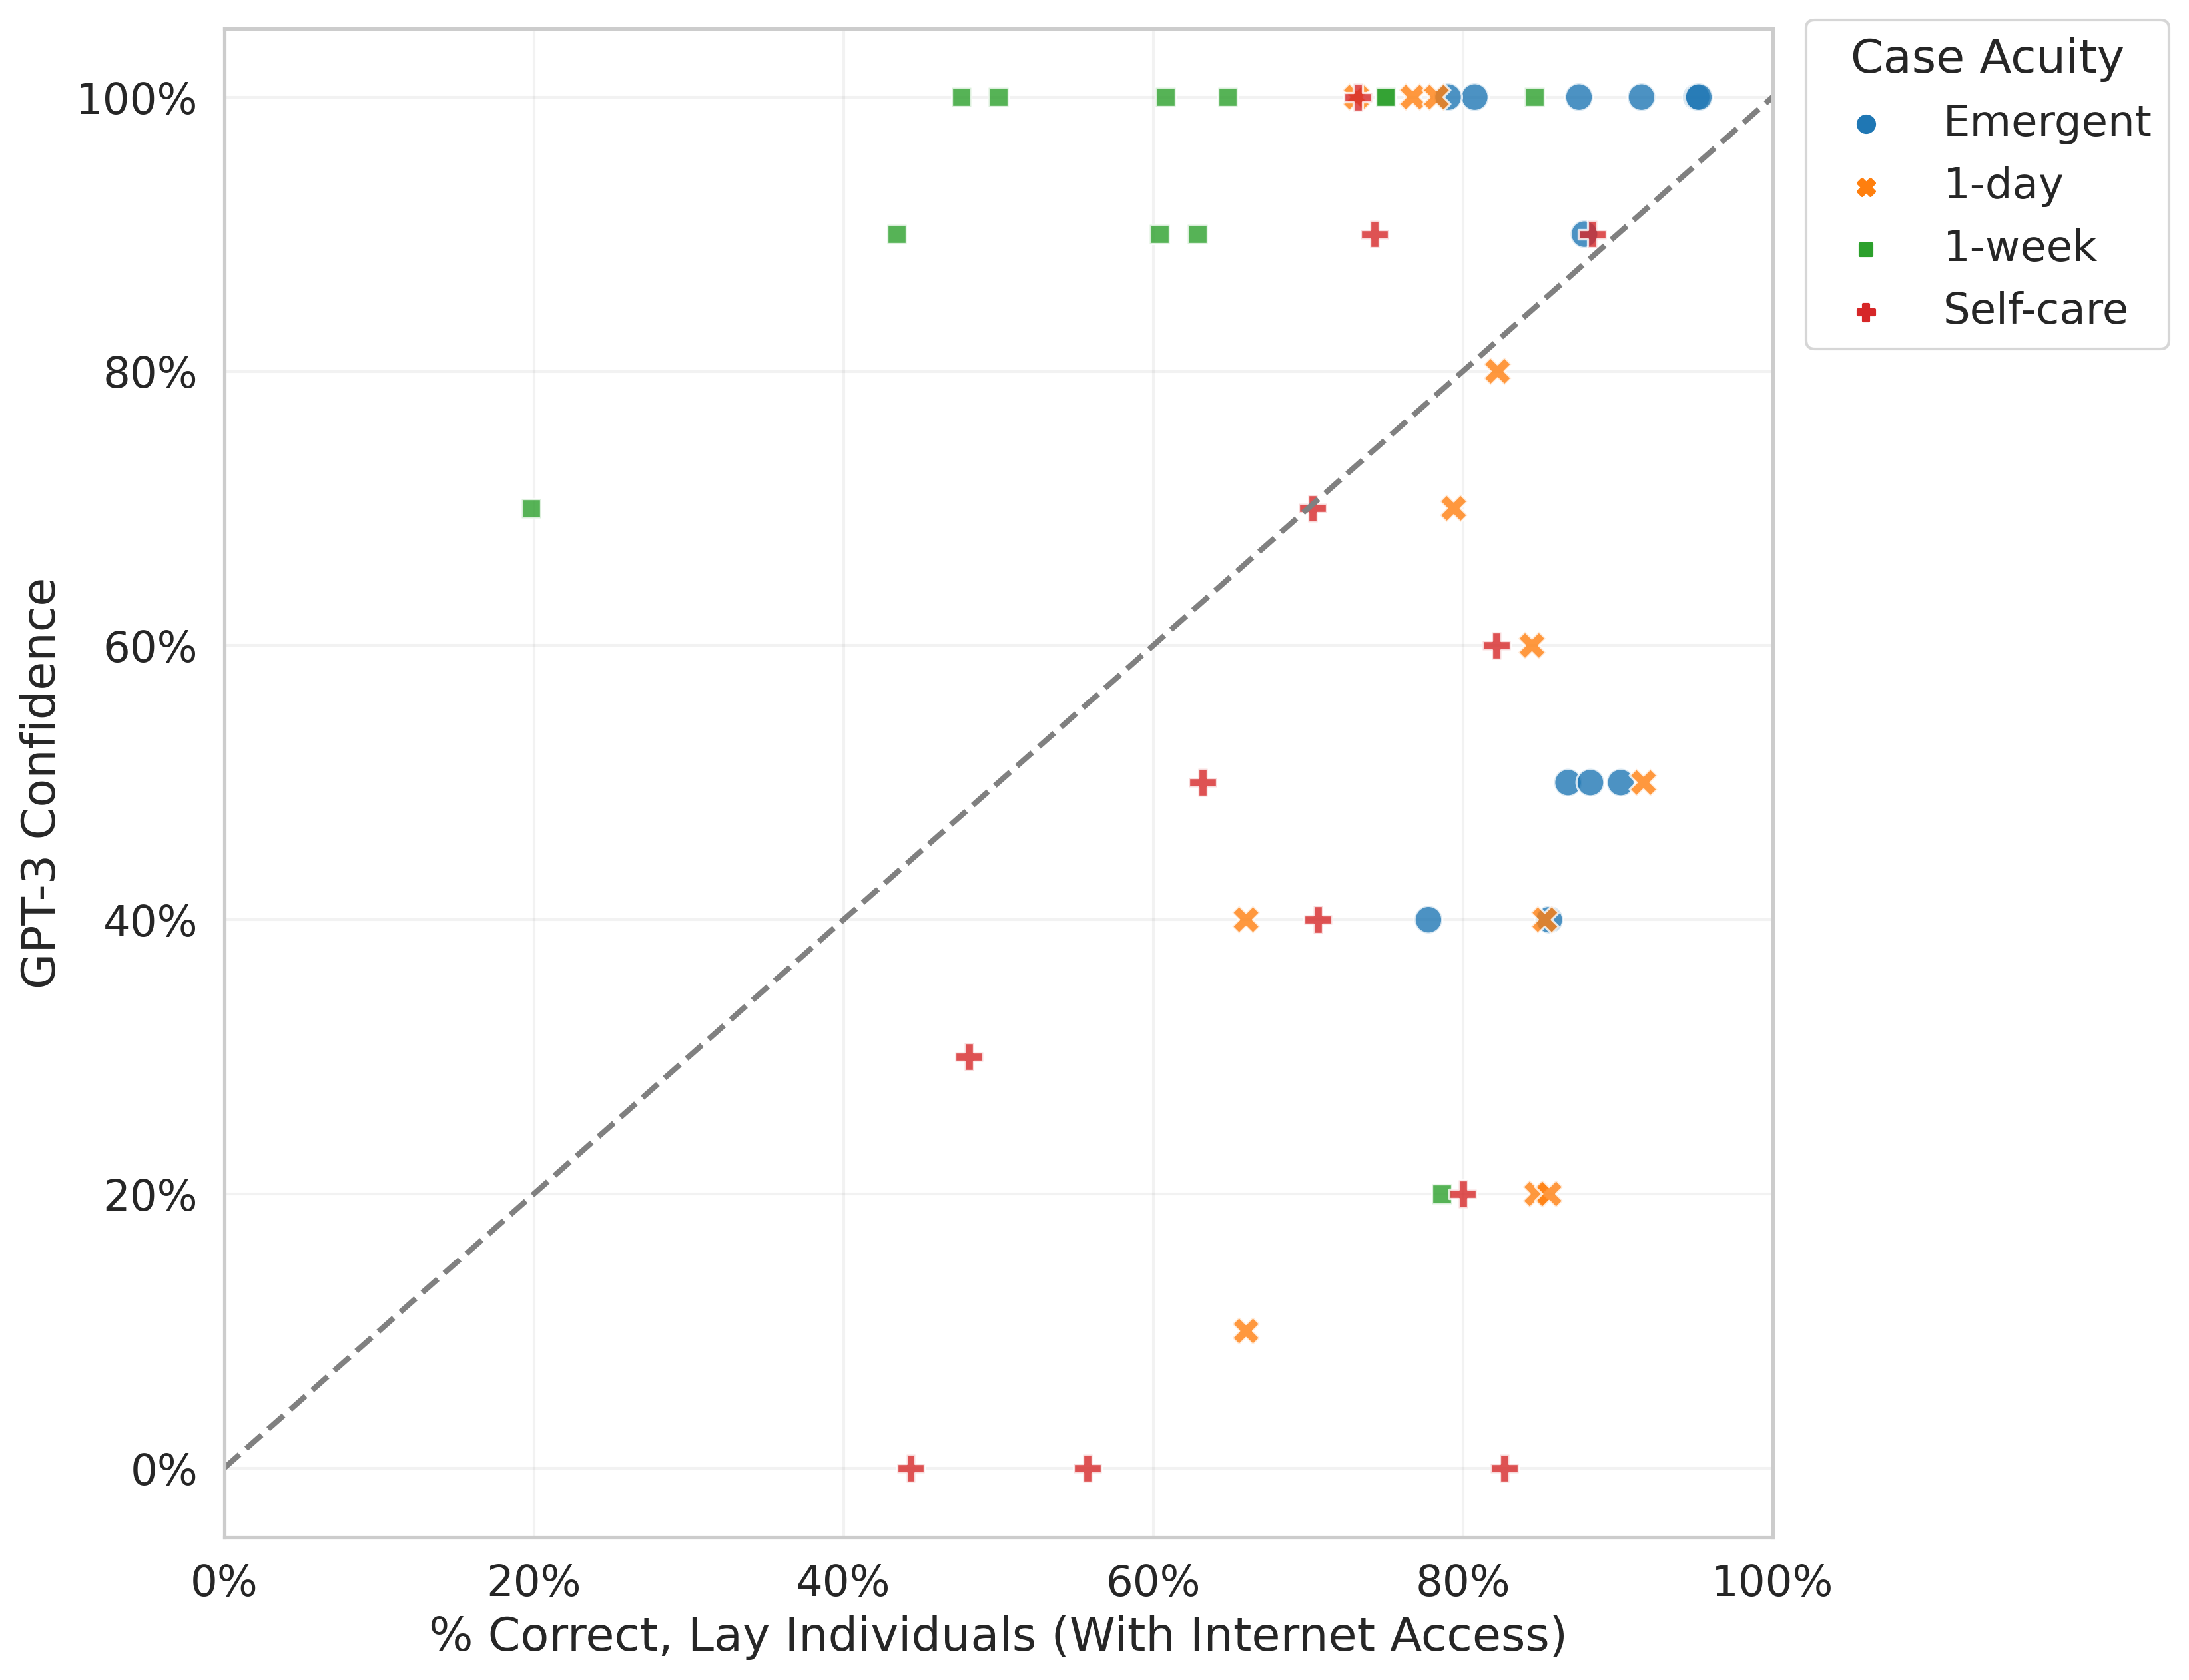

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

g = sns.scatterplot(
    x=per_vignette_human["Accuracy"]*100,
    y=per_vignette_gpt3_dich["Pr(correct prediction)"]*100,
    hue=per_vignette_human["Correct Triage"],
    s=100,
    alpha=0.8,
    ax=ax,
    style=per_vignette_human["Correct Triage"],
)
g.legend(loc='upper right', bbox_to_anchor=(1.27, 1.02), title="Case Acuity")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed")
ax.set_xlim((0, 100))
ax.grid(color="grey", alpha=0.1)
ax.set_ylabel("GPT-3 Confidence")
ax.set_xlabel("% Correct, Lay Individuals (With Internet Access)")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

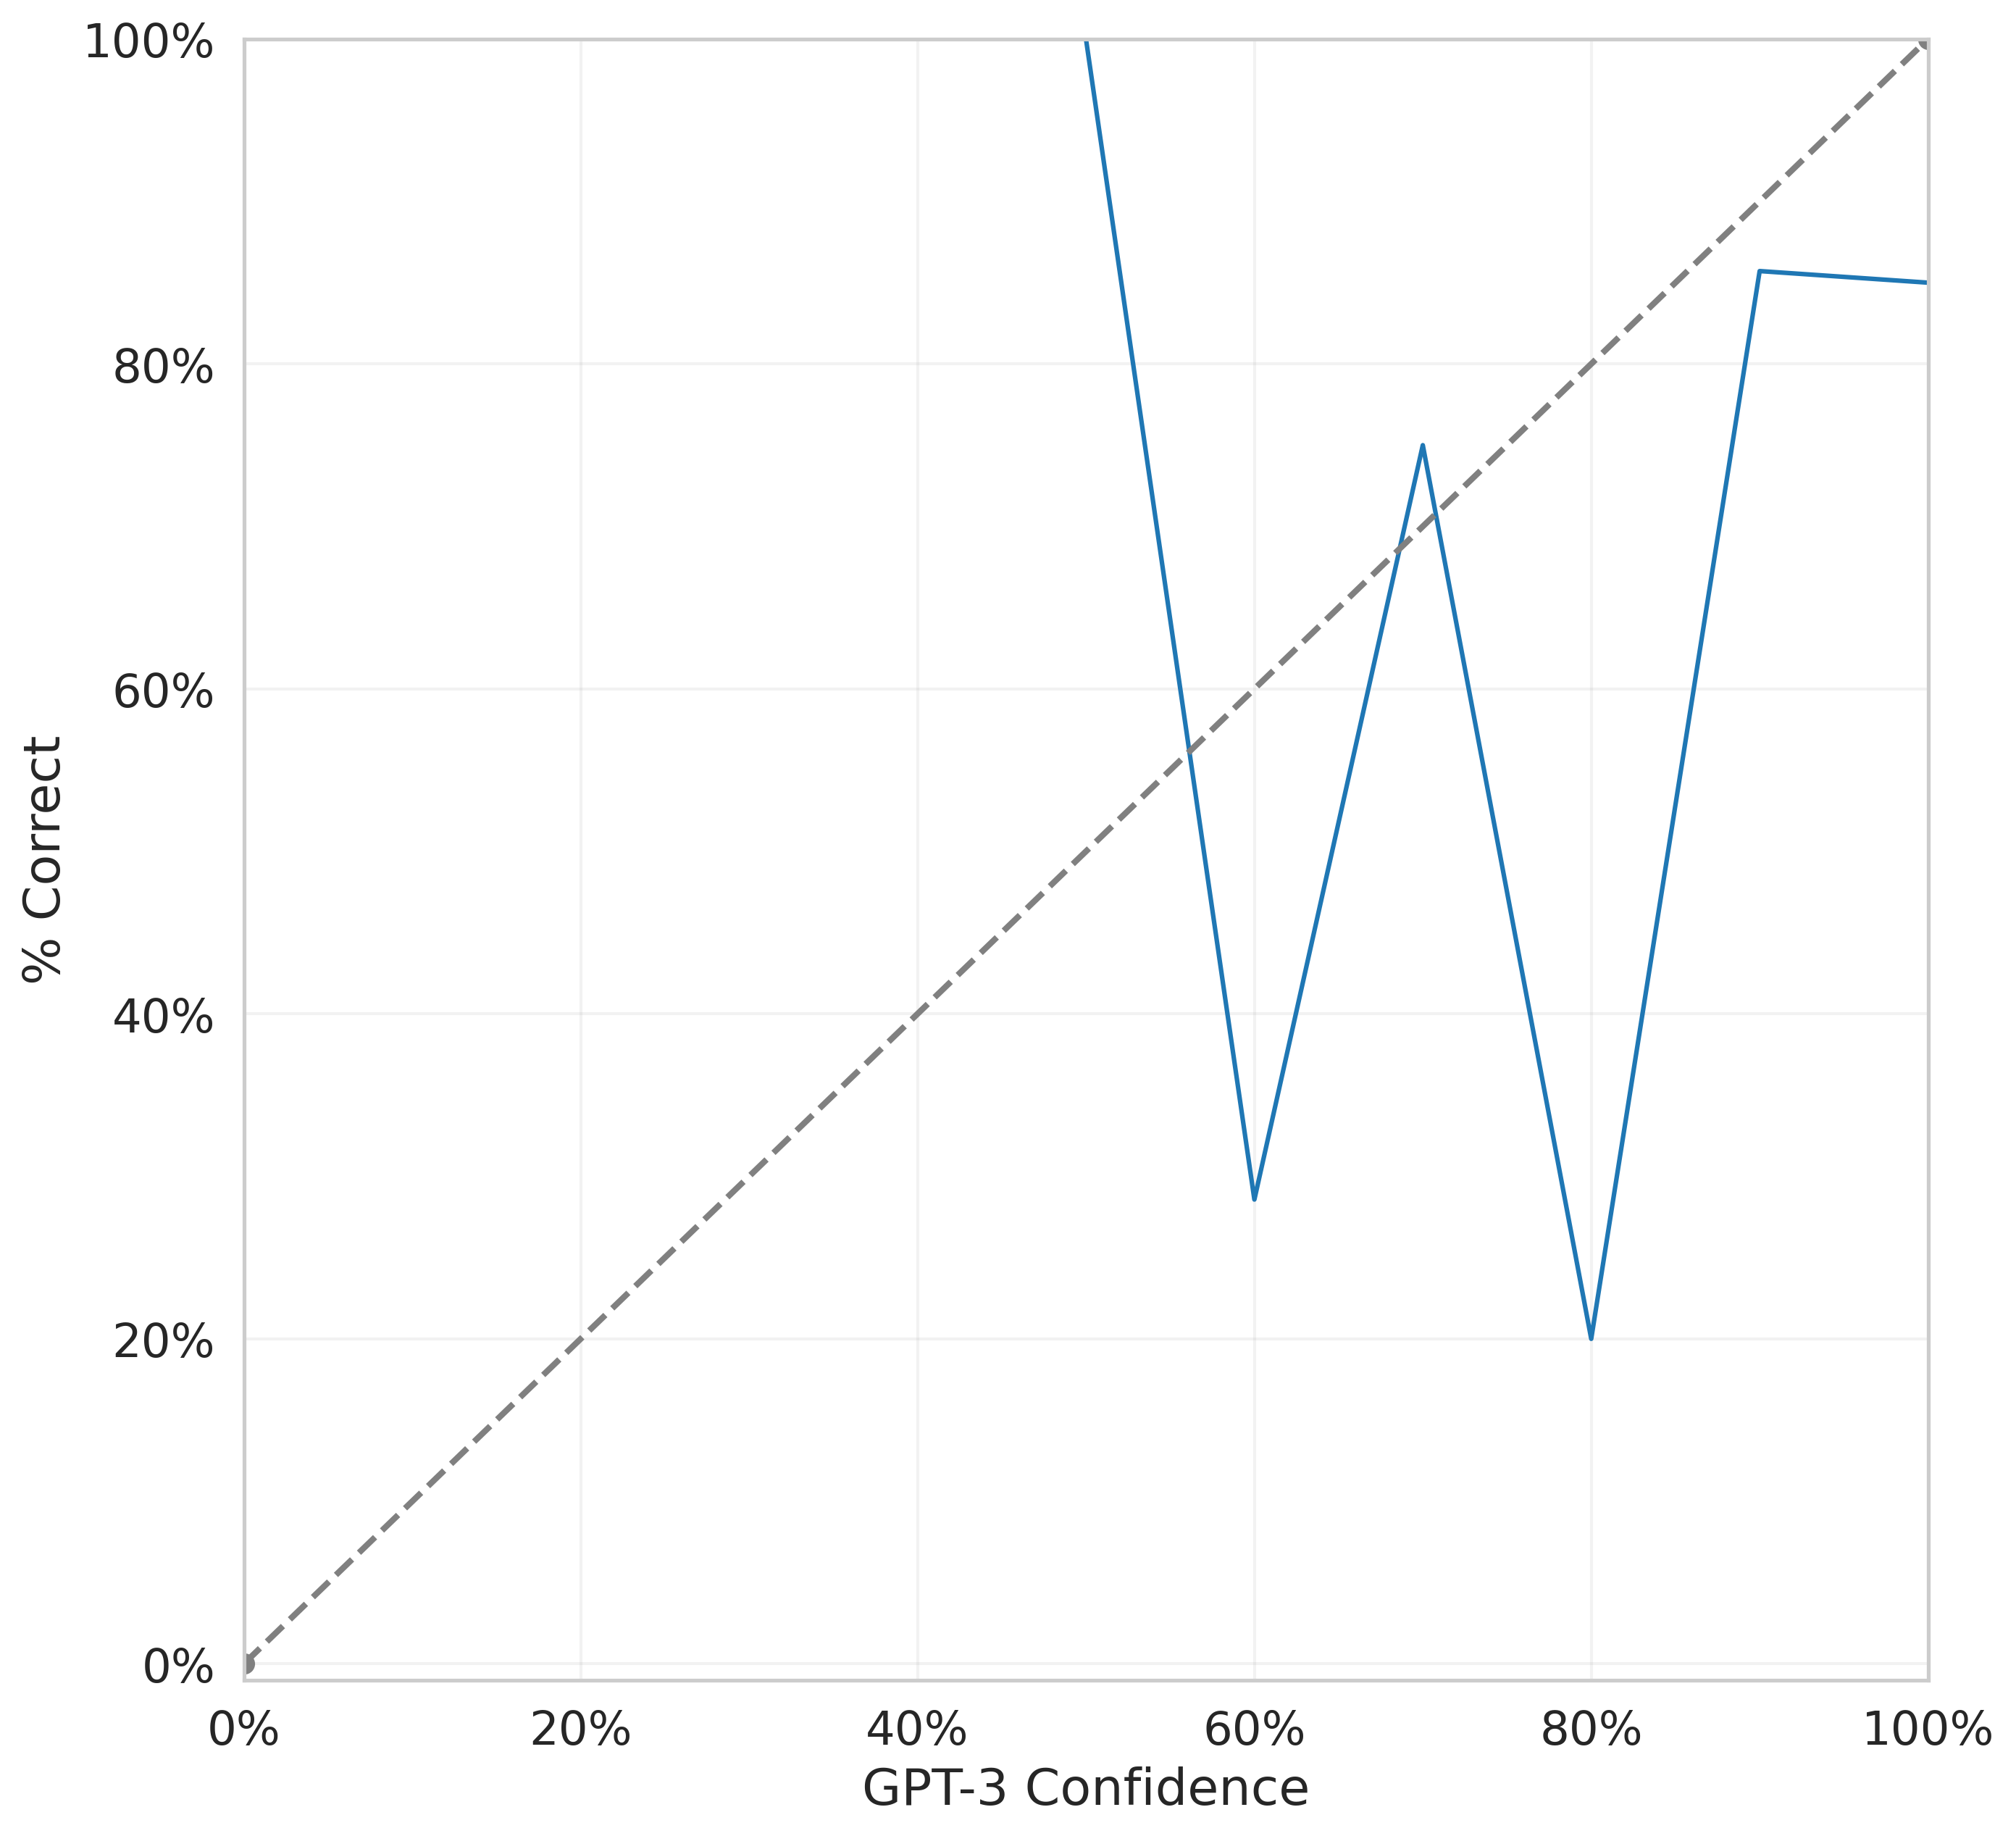

In [25]:
# Get empirical and true probabilities
y, x = calibration_curve(
    per_vignette_gpt3_dich["Correct"],
    per_vignette_gpt3_dich["Pr(prediction)"],
    n_bins=10
)
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=x*100, y=y*100, ax=ax)
ax.set_xlabel("GPT-3 Confidence")
ax.set_ylabel("% Correct")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed",  marker='o')
ax.grid(color="grey", alpha=0.1)
ax.set_ylim(-1,100)
ax.set_xlim(0,100)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

### Exact

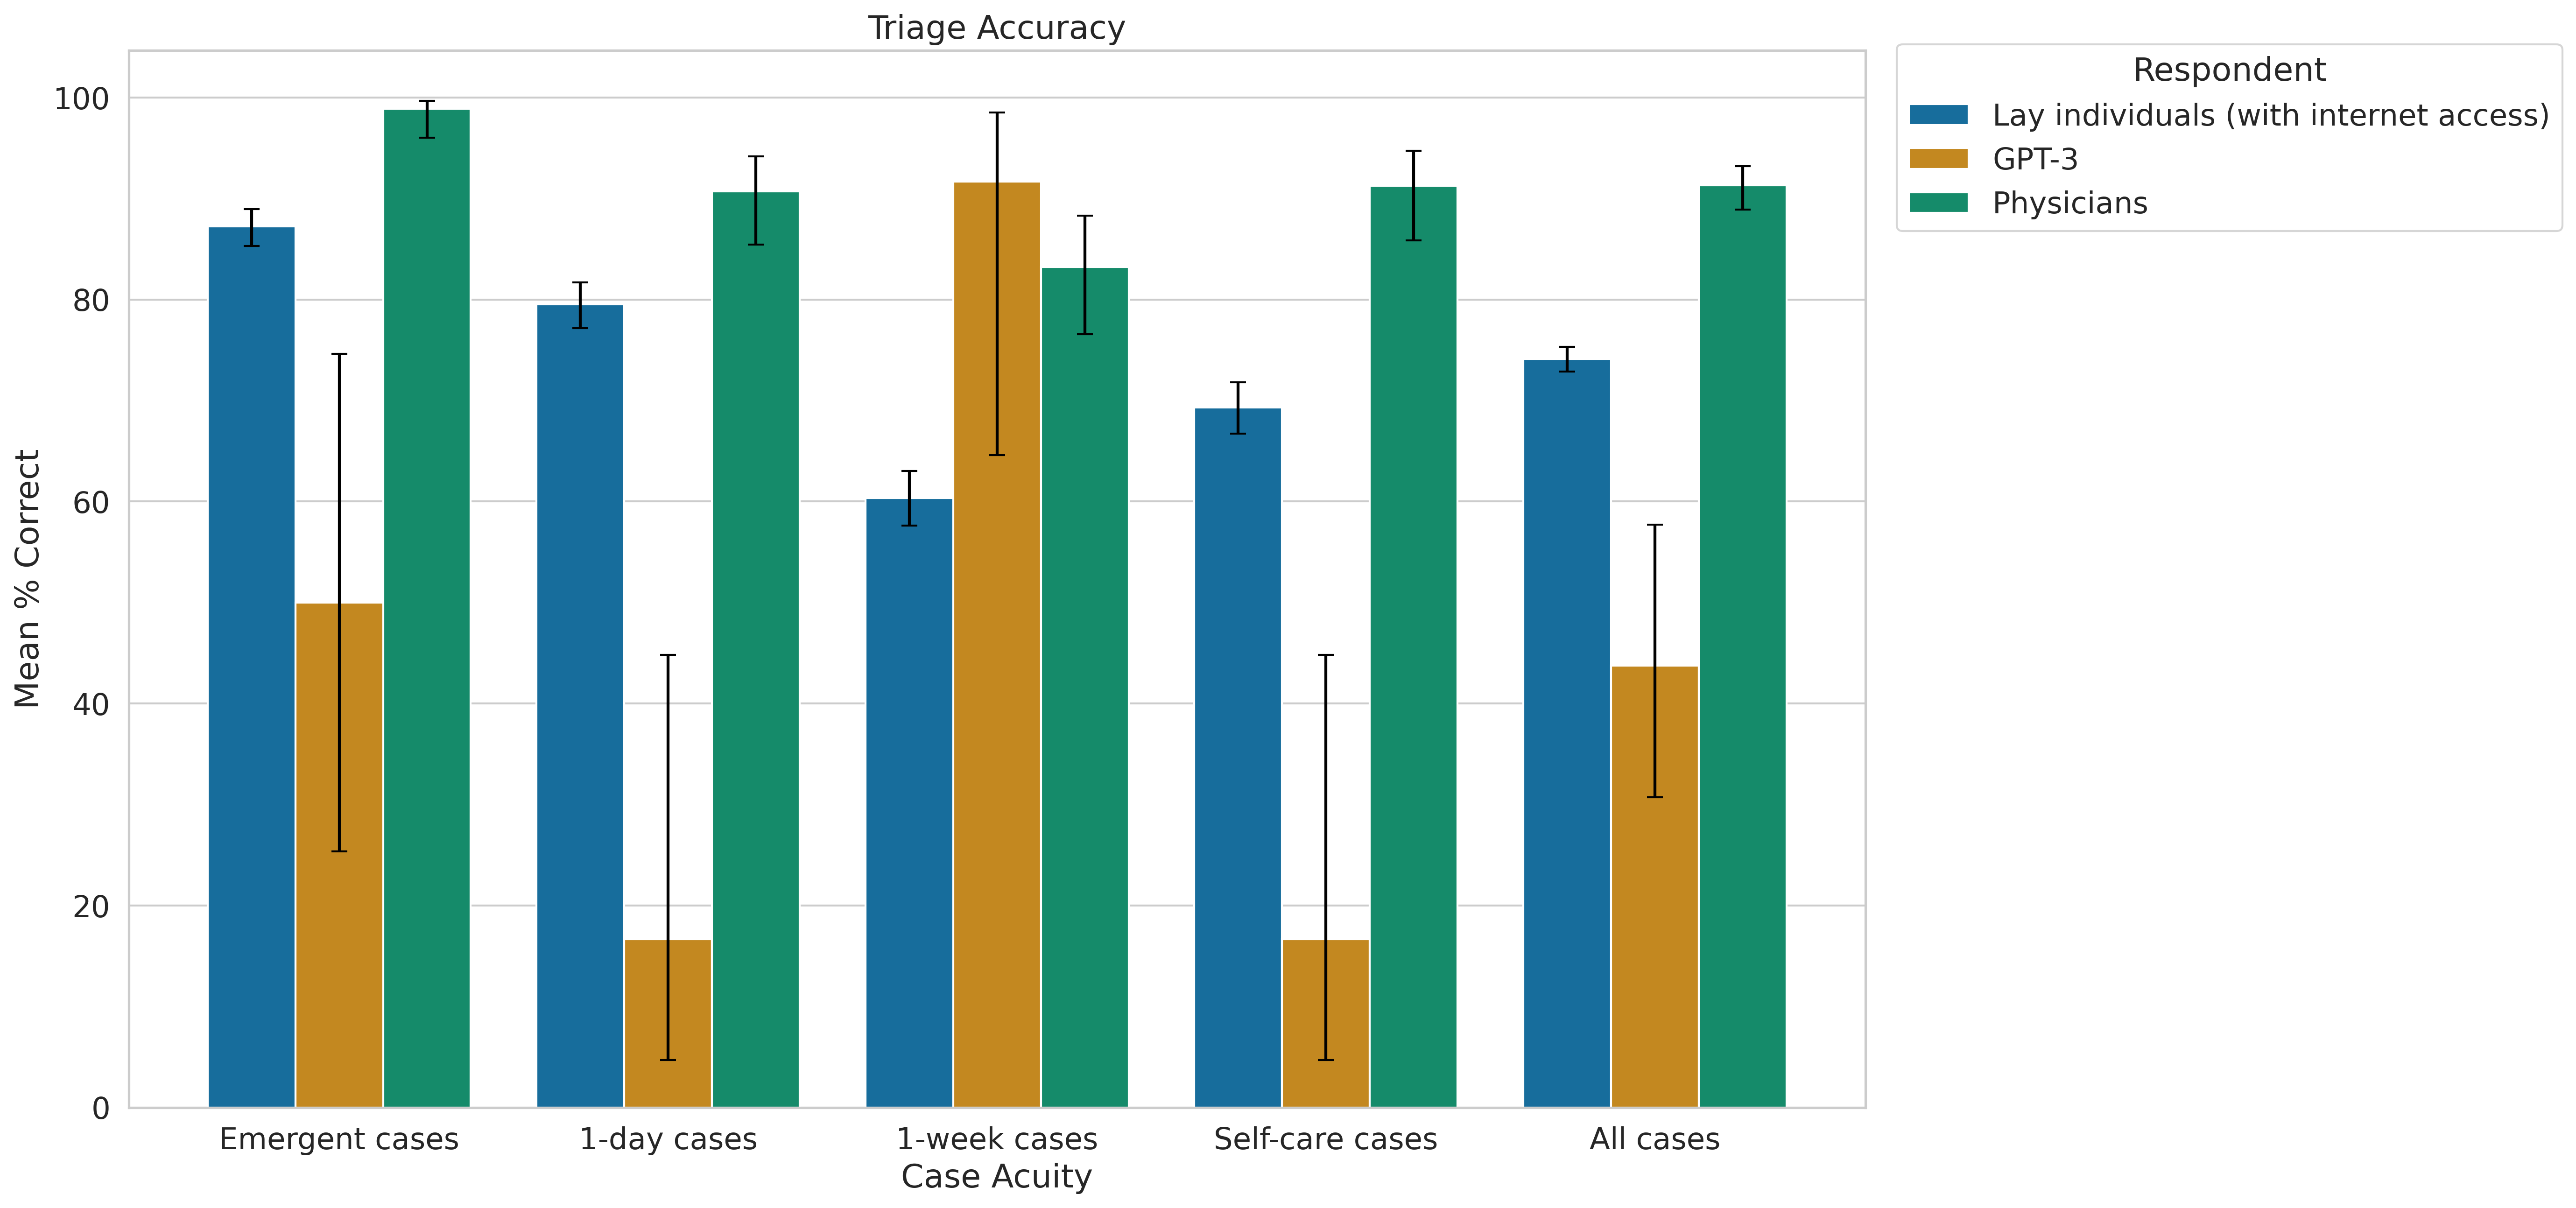

In [26]:
triage_perf = pd.concat([human_triage_perf, gpt3_triage_perf_exact, md_triage_perf])
triage_perf['Respondent'] = ['Lay individuals (with internet access)']*5 +\
    ['GPT-3']*5 +\
    ['Physicians']*5
triage_perf.index.name = "Case Acuity"
triage_perf.reset_index(inplace=True)

row_order = ["Emergent", "1-day", "1-week", "Self-care", "All"]

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=triage_perf, 
            x='Case Acuity', 
            y='Mean',
            hue='Respondent',
            ax=ax,
            order=row_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Triage Accuracy")

tmp = triage_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp["LB"] = -(tmp["LB"]-tmp["Mean"])
tmp["UB"] = tmp["UB"] - tmp["Mean"]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[["LB", "UB"]].values.T,
            ls='none', fmt='k', capsize=4);

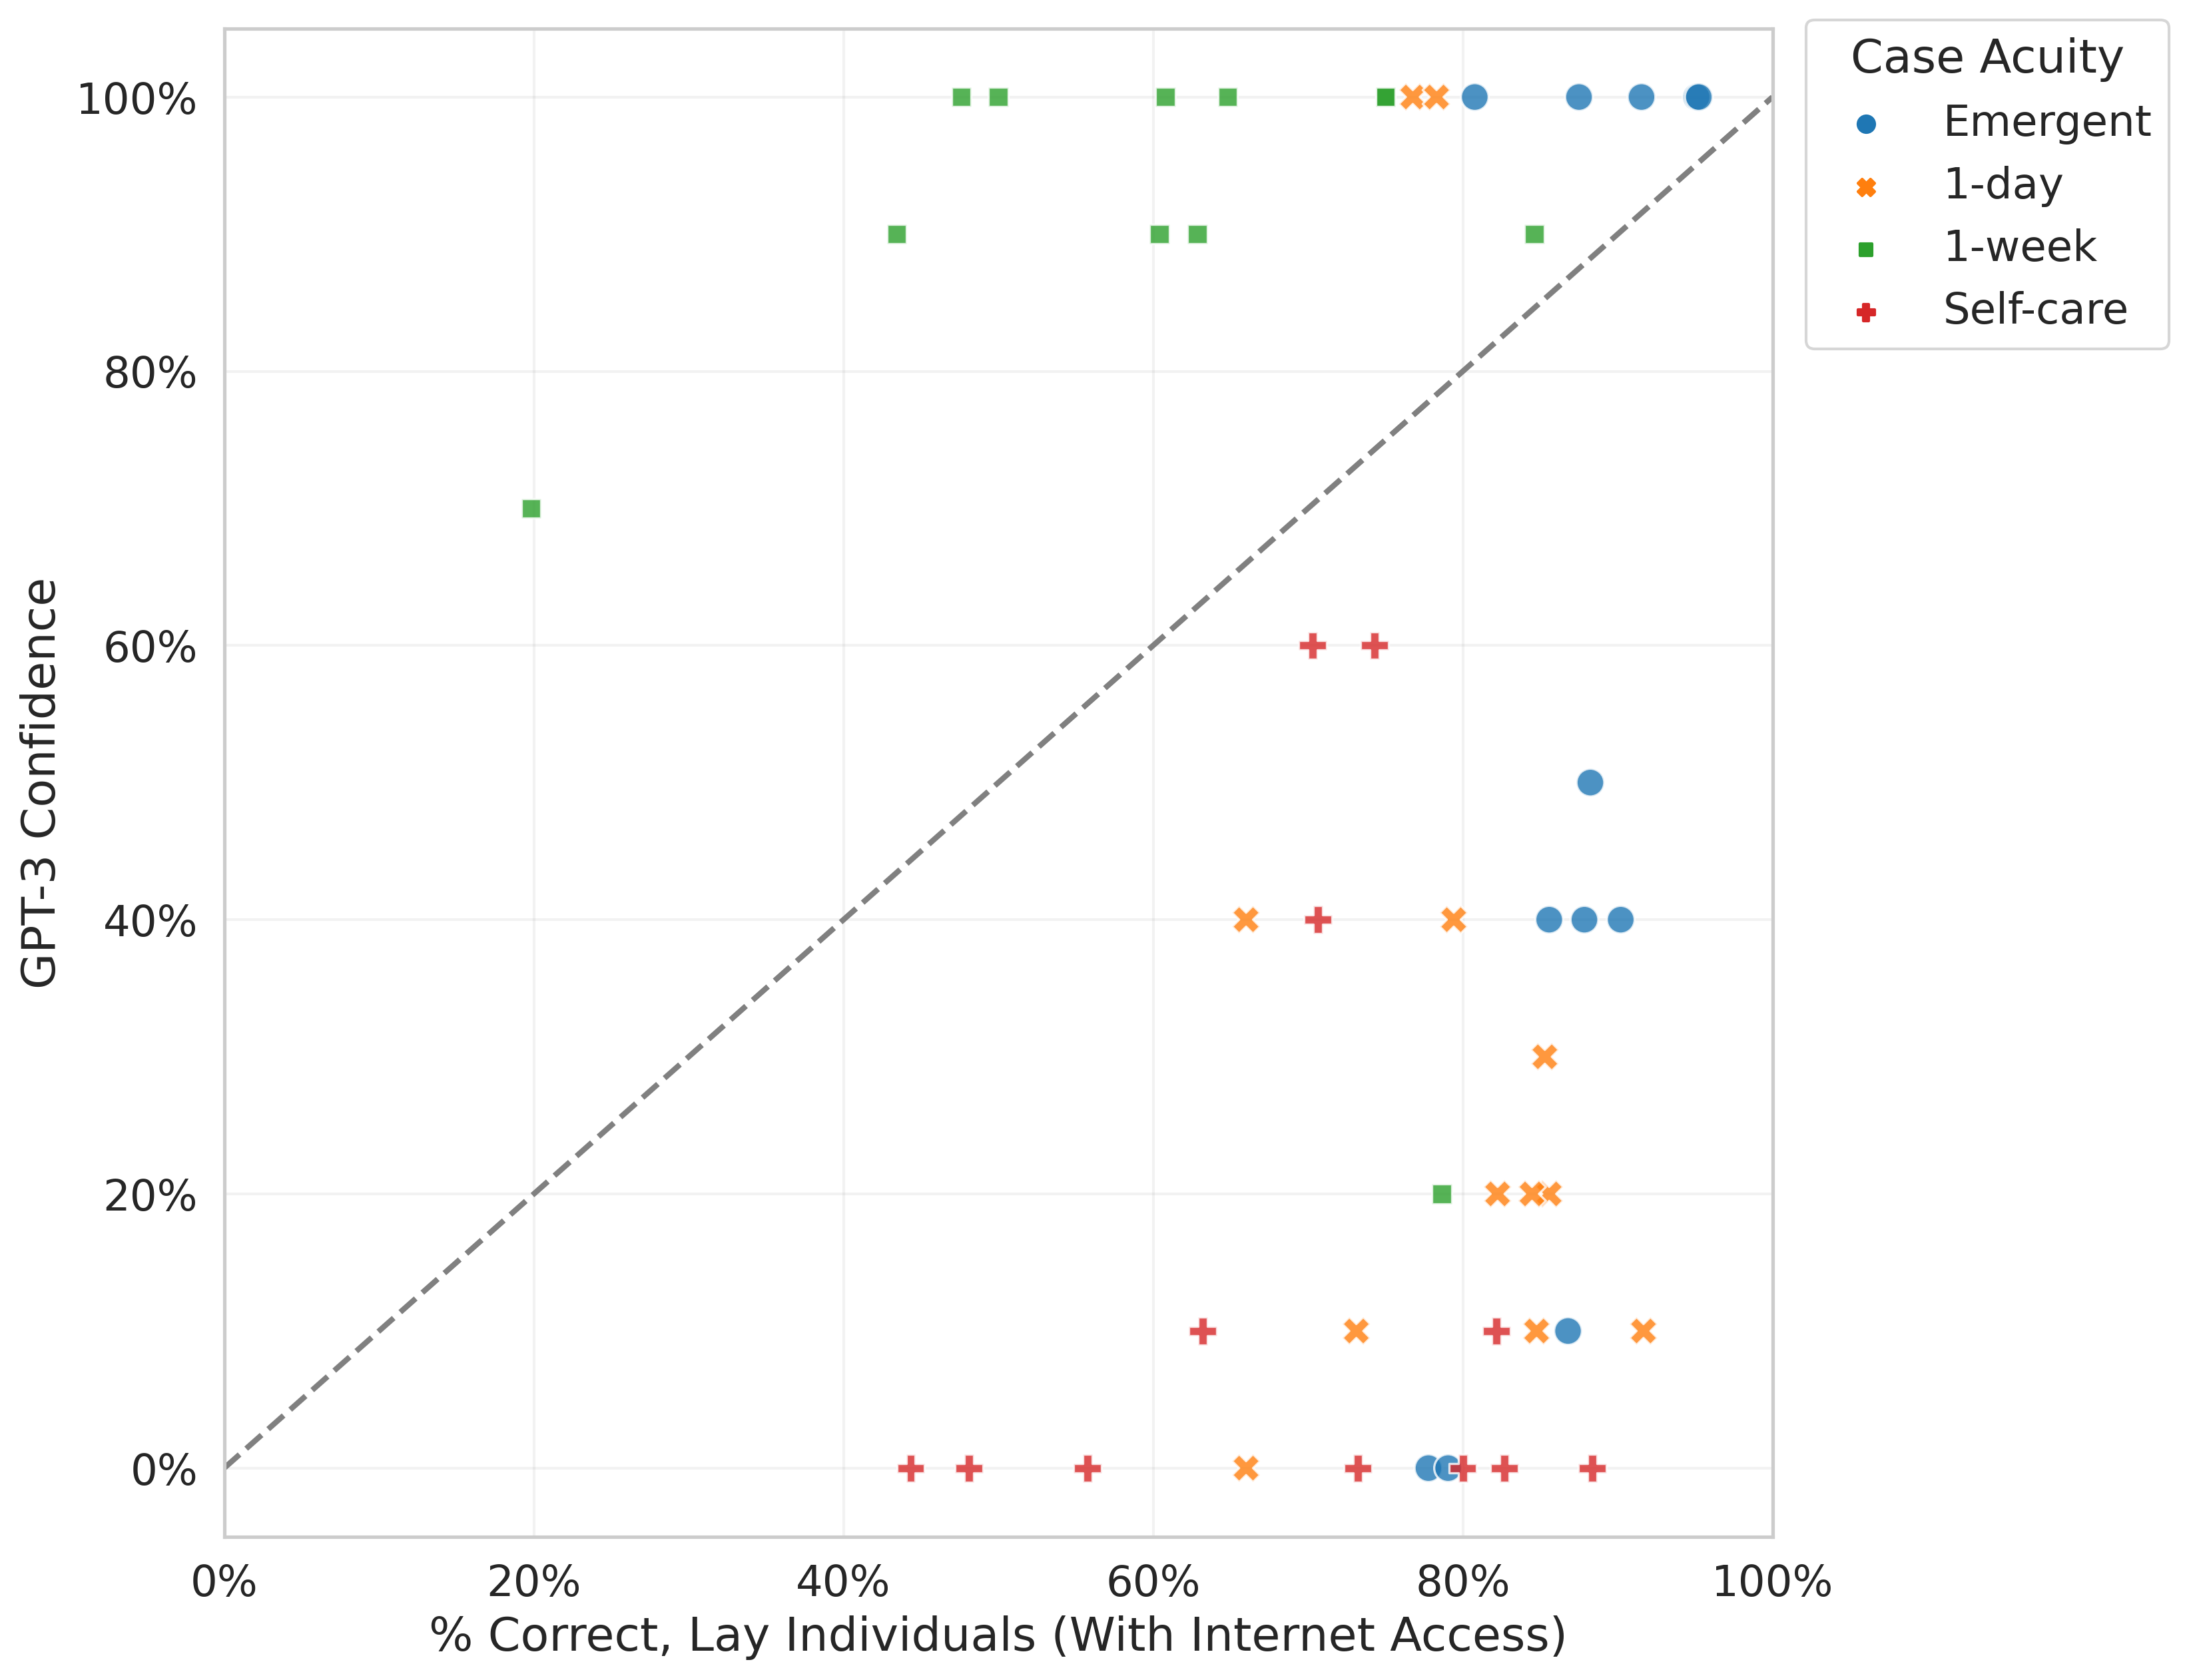

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

g = sns.scatterplot(
    x=per_vignette_human["Accuracy"]*100,
    y=per_vignette_gpt3_exact["Pr(correct prediction)"]*100,
    hue=per_vignette_human["Correct Triage"],
    s=100,
    alpha=0.8,
    ax=ax,
    style=per_vignette_human["Correct Triage"],
)
g.legend(loc='upper right', bbox_to_anchor=(1.27, 1.02), title="Case Acuity")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed")
ax.set_xlim((0, 100))
ax.grid(color="grey", alpha=0.1)
ax.set_ylabel("GPT-3 Confidence")
ax.set_xlabel("% Correct, Lay Individuals (With Internet Access)")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

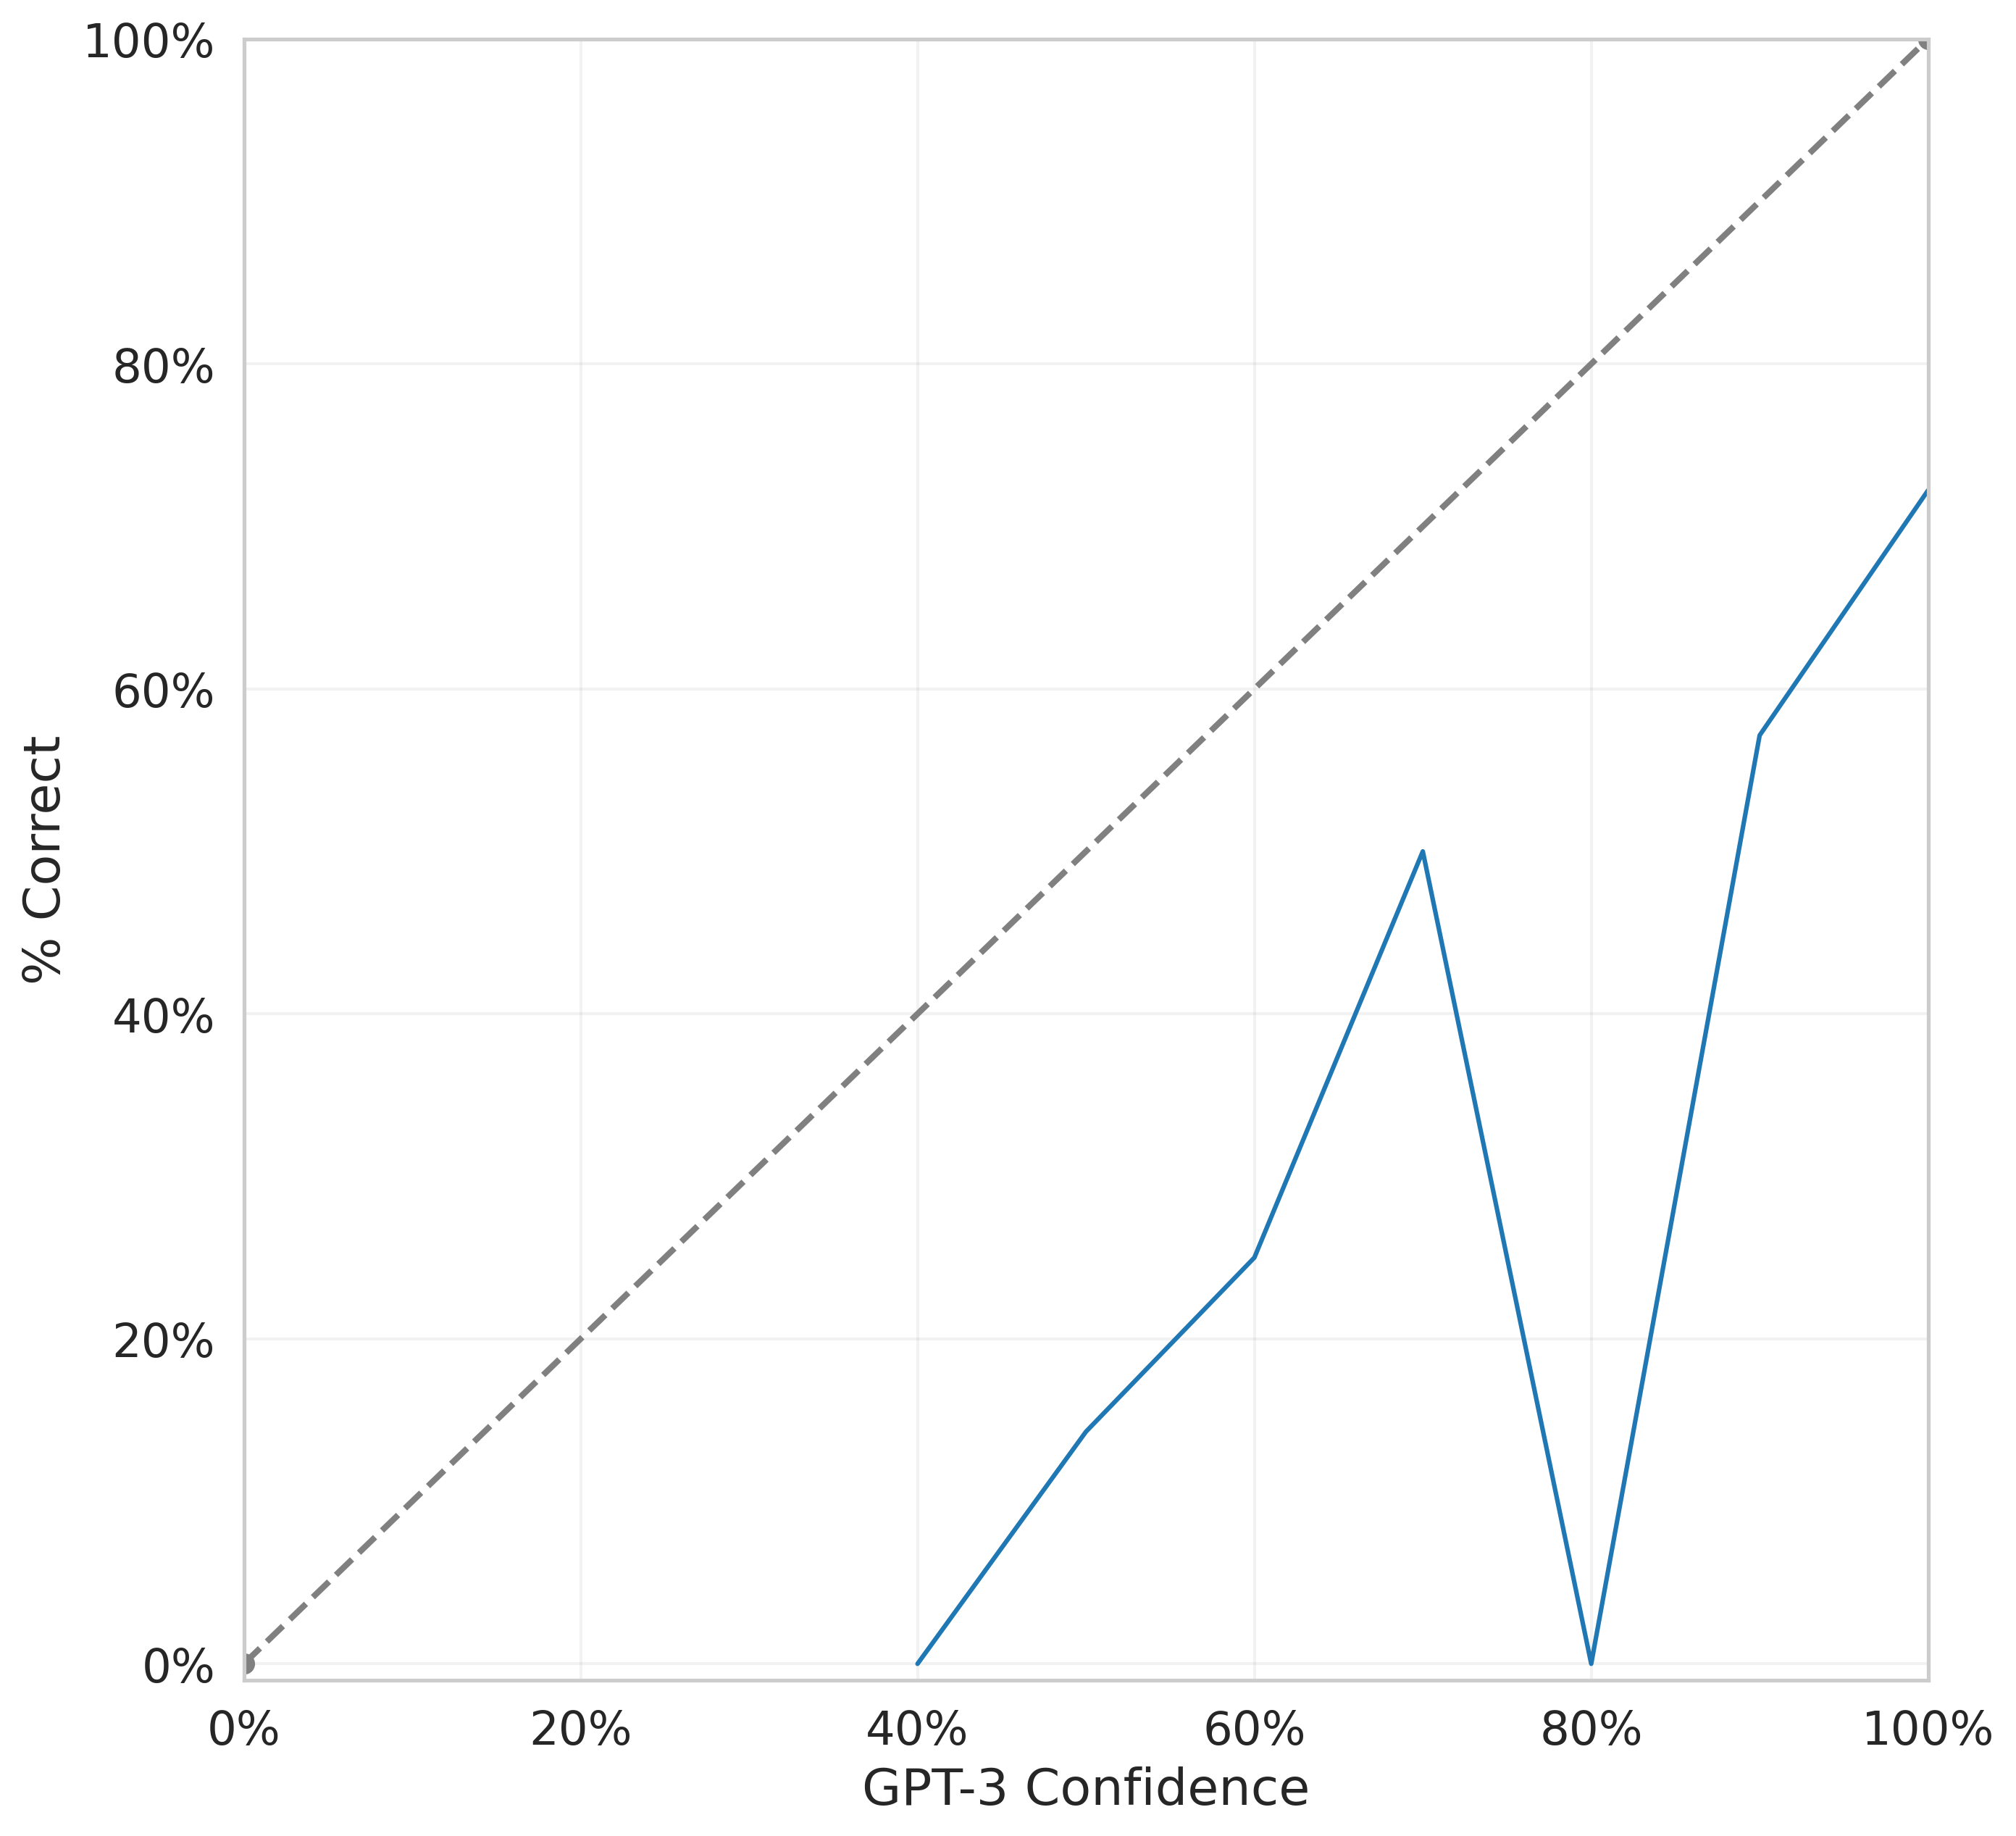

In [28]:
# Get empirical and true probabilities
y, x = calibration_curve(
    per_vignette_gpt3_exact["Correct"],
    per_vignette_gpt3_exact["Pr(prediction)"],
    n_bins=10
)
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=x*100, y=y*100, ax=ax)
ax.set_xlabel("GPT-3 Confidence")
ax.set_ylabel("% Correct")
ax.axline((0, 0), slope=1, linewidth=2, color='grey', linestyle="dashed",  marker='o')
ax.grid(color="grey", alpha=0.1)
ax.set_ylim(-1,100)
ax.set_xlim(0,100)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.PercentFormatter())